# **SSCS - Training**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 1 - Initialization

In [ ]:
import time
import numpy as np
import tensorflow as tf
import sscs
import matplotlib.pyplot as plt

In [2]:
#Model: 0 = VoasCNN, 1 = Downsample, 2 = Mask, 3 = MaskV2
MODEL = 2
TRAINING_NUMBER = 3
SAVE_MODEL = False
LOAD_MODEL = True
TRAIN_MODEL = False
MODEL_SUMMARY = True
L_RATE = 5e-3

F_SCORE_PRECOMPUTE = False
F_SCORE_LOAD = True
F_SCORE_PLOTS = True

## 2 - Download and extract dataset SSCS

In [3]:
sscs.download()

SSCS Dataset found.
SSCS Dataset already extracted.
Done.


## 3 - Training Model

In [ ]:
ds_train = sscs.get_dataset(split='train', end_index=1000)
ds_val = sscs.get_dataset(split='validate', end_index=300)
ds_test = sscs.get_dataset(split='test', end_index=300)

In [5]:
if (MODEL == 0):
    ckpt_dir = './Checkpoints/voas_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.voas_cnn_model(l_rate = L_RATE)
    log_folder = 'voas_cnn'
elif (MODEL == 1):
    ckpt_dir = './Checkpoints/downsample_voas_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.downsample_voas_cnn_model(l_rate = L_RATE)
    log_folder = 'downsample_voas_cnn'
elif (MODEL == 2):
    ckpt_dir = './Checkpoints/mask_voas_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.mask_voas_cnn_model(l_rate = L_RATE)
    log_folder = 'mask_voas_cnn'
elif (MODEL == 3):
    ckpt_dir = './Checkpoints/mask_voas_v2_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.mask_voas_cnn_v2_model(l_rate = L_RATE)
    log_folder = 'mask_voas_v2'
else:
    ckpt_dir = './Checkpoints/voas_treino' + str(TRAINING_NUMBER) + '.keras'
    model = sscs.voas_cnn_model(l_rate = L_RATE)
    log_folder = 'voas_cnn'

f_score_dir = './Evaluation_Data/' + log_folder + '_f-scores_treino' + str(TRAINING_NUMBER) + '.npy'

if MODEL_SUMMARY:
    print(model.summary())

print(ckpt_dir)
if LOAD_MODEL:
    sscs.load_weights(model, ckpt_dir=ckpt_dir)

if TRAIN_MODEL:
    sscs.train(model, ds_train, ds_val, epochs=15, save_model=SAVE_MODEL,
               ckpt_dir=ckpt_dir, log_folder=log_folder)  
    

Model: "MaskVoasCNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 360, 256, 1)]        0         []                            
                                                                                                  
 downscale (Resizing)        (None, 90, 128, 1)           0         ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 90, 128, 1)           4         ['downscale[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 conv1 (Conv2D)              (None, 90, 128, 32)          320       ['batch_normalizatio

## 4 - Evaluation with F-Score

In [6]:
songs = sscs.pick_songlist(amount=805, split='test')
#songs = sscs.pick_songlist(amount=300, split='test')

def multivoice_f_score(song):
    mix, s, a, t, b = sscs.read_all_voice_splits(song)
    s_pred, a_pred, t_pred, b_pred = model.predict(mix)

    mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
    s = np.moveaxis(s, 0, 1).reshape(360, -1)
    a = np.moveaxis(a, 0, 1).reshape(360, -1)
    t = np.moveaxis(t, 0, 1).reshape(360, -1)
    b = np.moveaxis(b, 0, 1).reshape(360, -1)

    s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
    a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
    t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
    b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
    mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
    mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

    s_fscore = sscs.f_score(s, s_pred_postproc)
    a_fscore = sscs.f_score(a, a_pred_postproc)
    t_fscore = sscs.f_score(t, t_pred_postproc)
    b_fscore = sscs.f_score(b, b_pred_postproc)

    return [s_fscore, a_fscore, t_fscore, b_fscore]



if(F_SCORE_PRECOMPUTE):
    f_scores = np.array(list(map(multivoice_f_score, songs)))
    f_scores = f_scores.T
    np.save(f_score_dir, f_scores)

In [7]:
if(F_SCORE_LOAD):
    f_scores = np.load(f_score_dir)

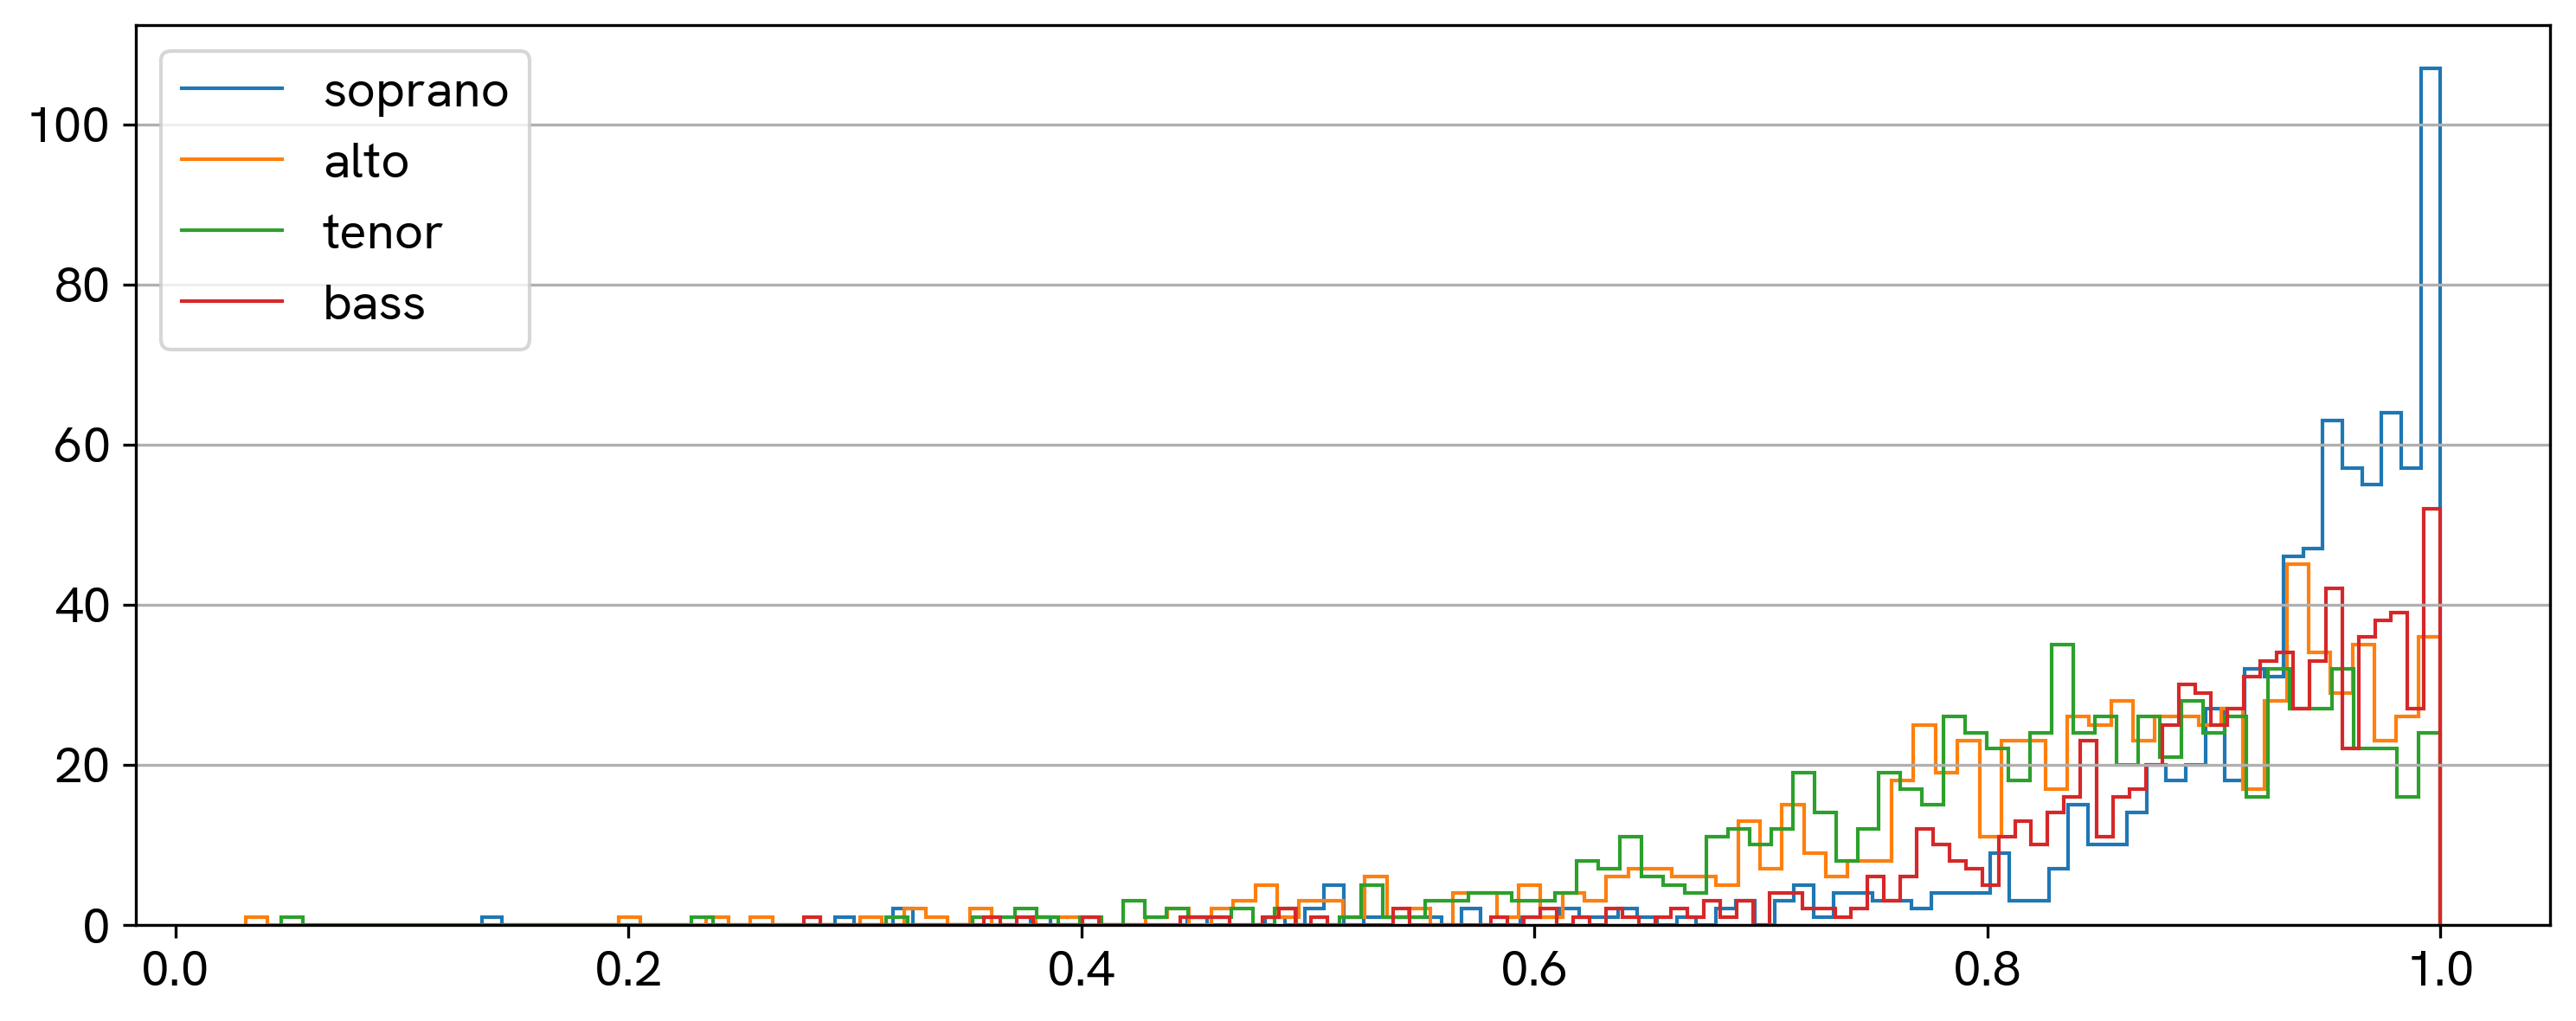

In [8]:
sscs.joint_f_histograms(f_scores)

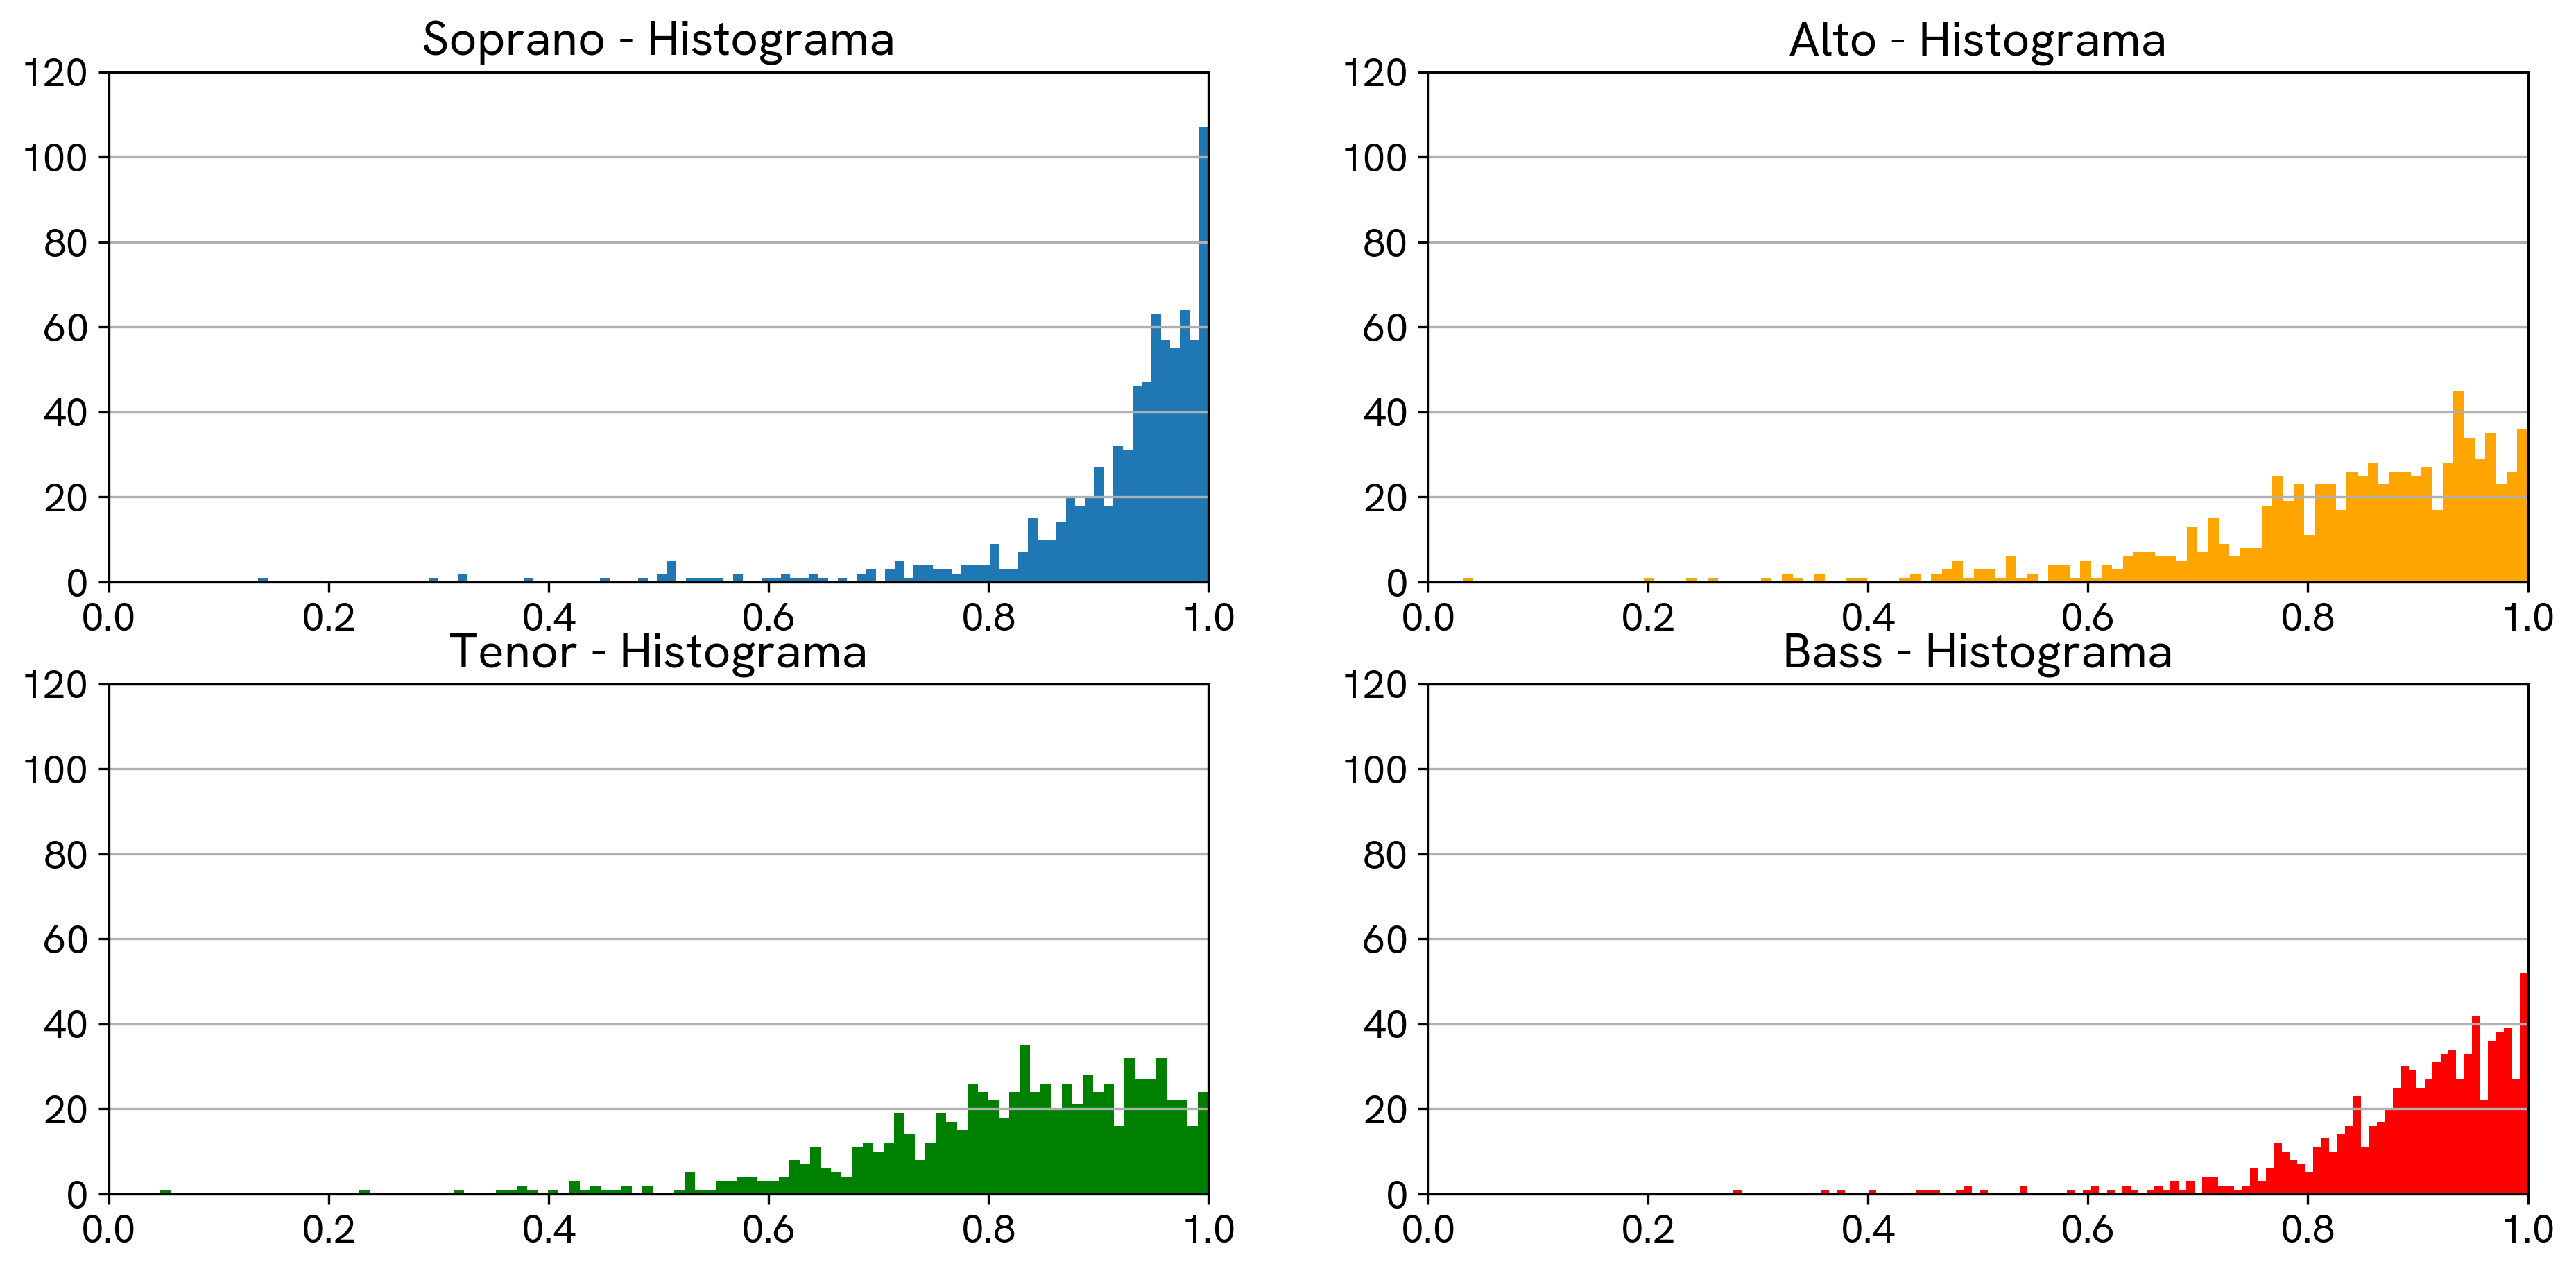

In [9]:
sscs.voice_f_histograms(f_scores)

0.948390101515154 0.8632812000000029 0.8430606117647087 0.9163115030303056


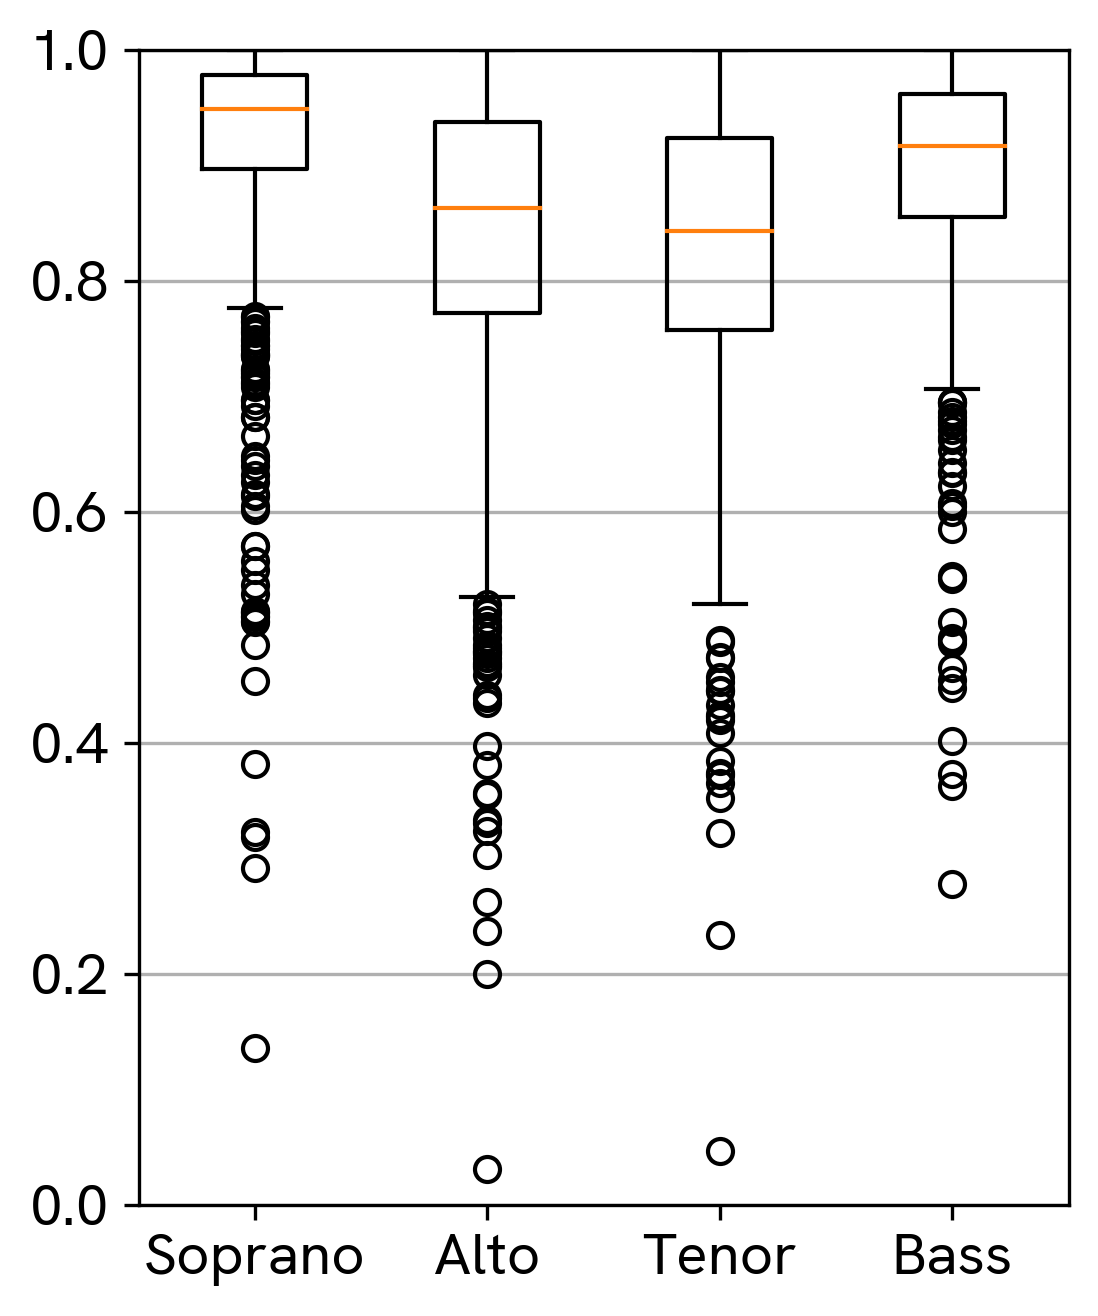

In [10]:
sscs.boxplot(f_scores)

## 5 - Visualizing the "mask"

In [11]:
print(model.layers[11].name)

upscale


In [ ]:
mask_activations    = tf.keras.models.Model(inputs=model.inputs,
                                            outputs=[   model.layers[10].output,
                                                        model.layers[11].output,
                                                        model.layers[12].output])

#mask_activations.summary()

rand_song = sscs.pick_random_song(split='test')
mix, s, a, t, b = sscs.read_all_voice_splits(rand_song)

conv_sigmoid, upscale, mask = mask_activations.predict(mix)
conv_sigmoid = np.moveaxis(conv_sigmoid, 0, 1).reshape(90, -1, 16)
upscale = np.moveaxis(upscale, 0, 1).reshape(360, -1, 16)
mask = np.moveaxis(mask, 0, 1).reshape(360, -1, 16)
mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
s = np.moveaxis(s, 0, 1).reshape(360, -1)
a = np.moveaxis(a, 0, 1).reshape(360, -1)
t = np.moveaxis(t, 0, 1).reshape(360, -1)
b = np.moveaxis(b, 0, 1).reshape(360, -1)

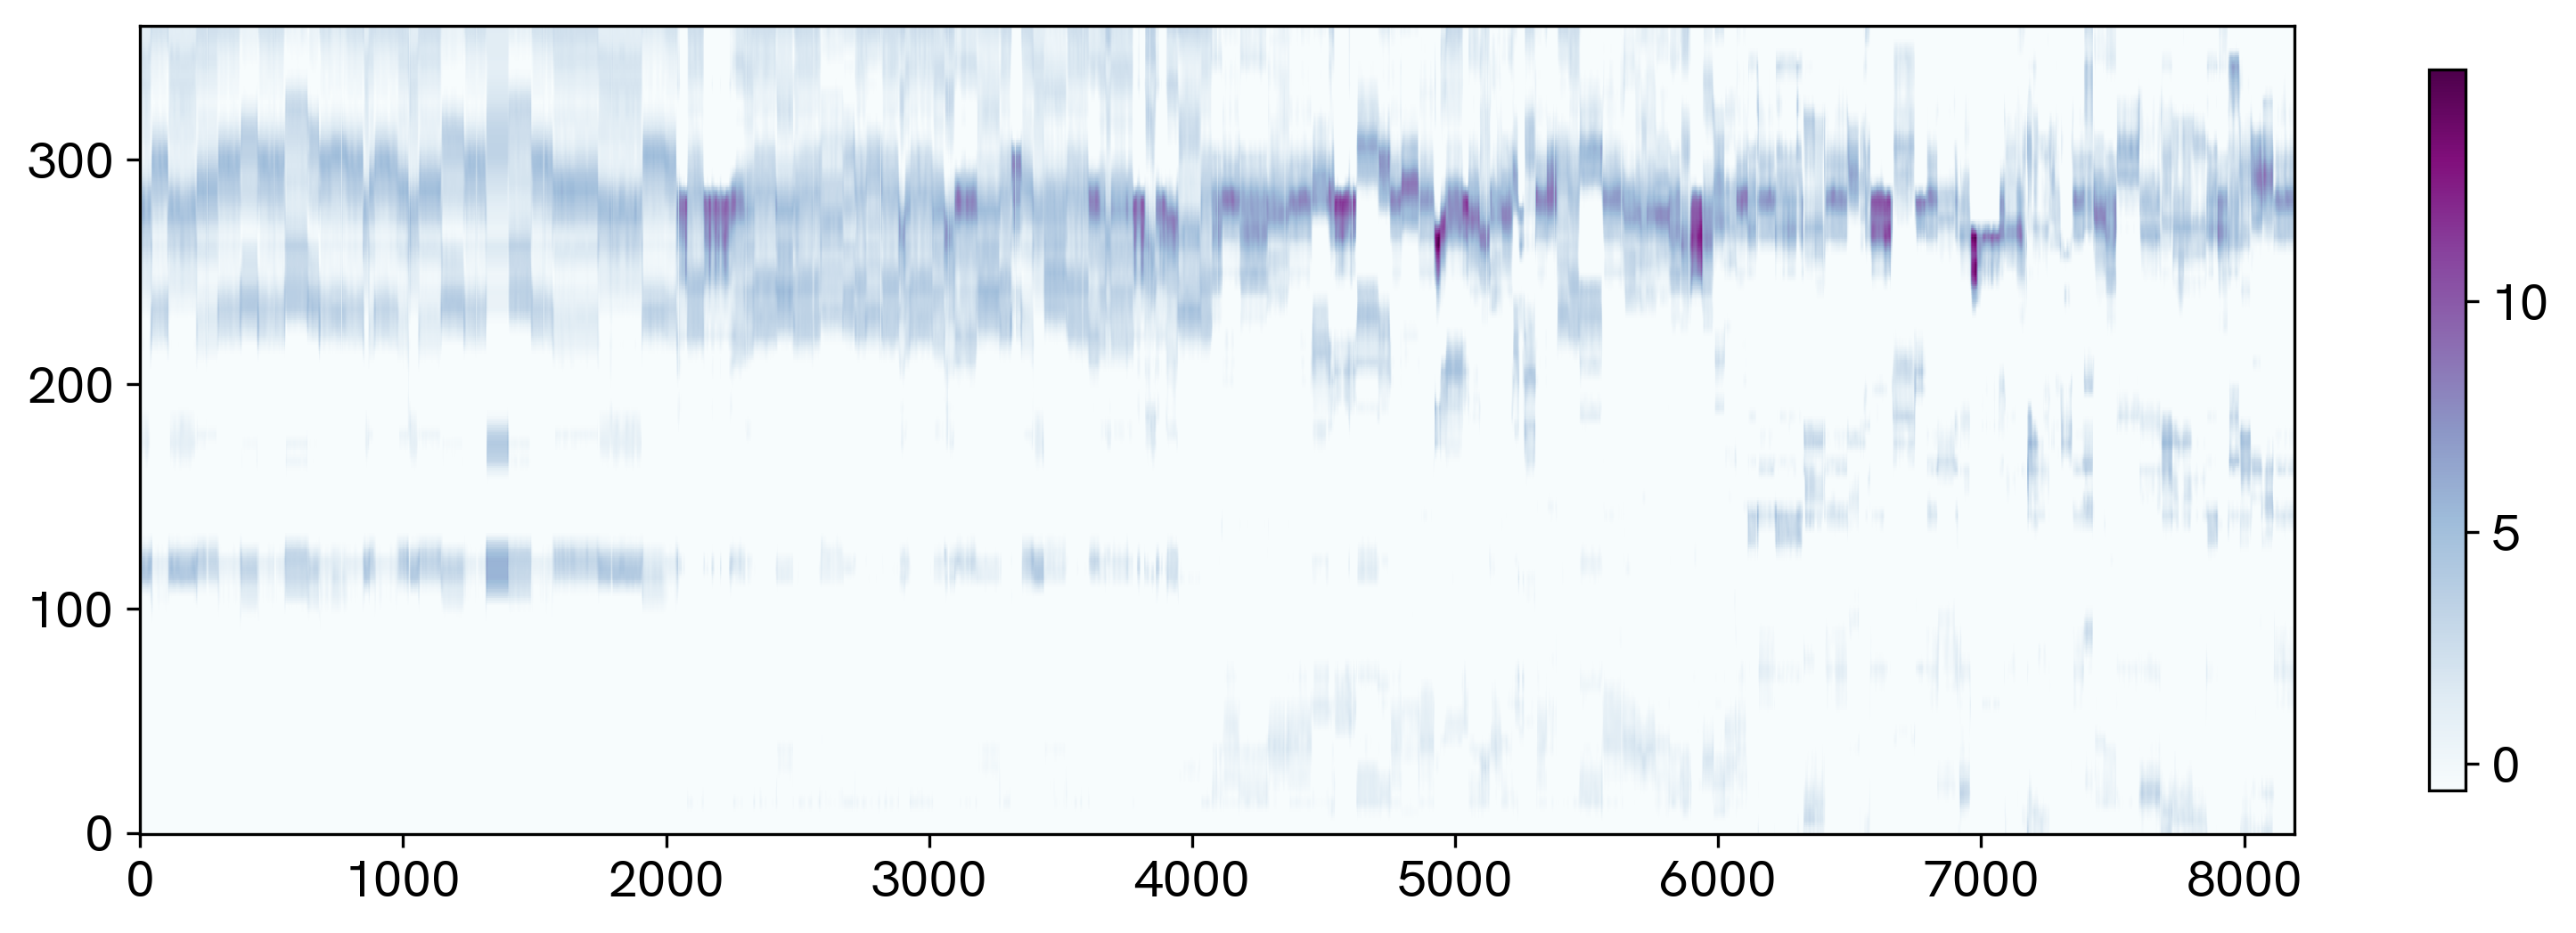

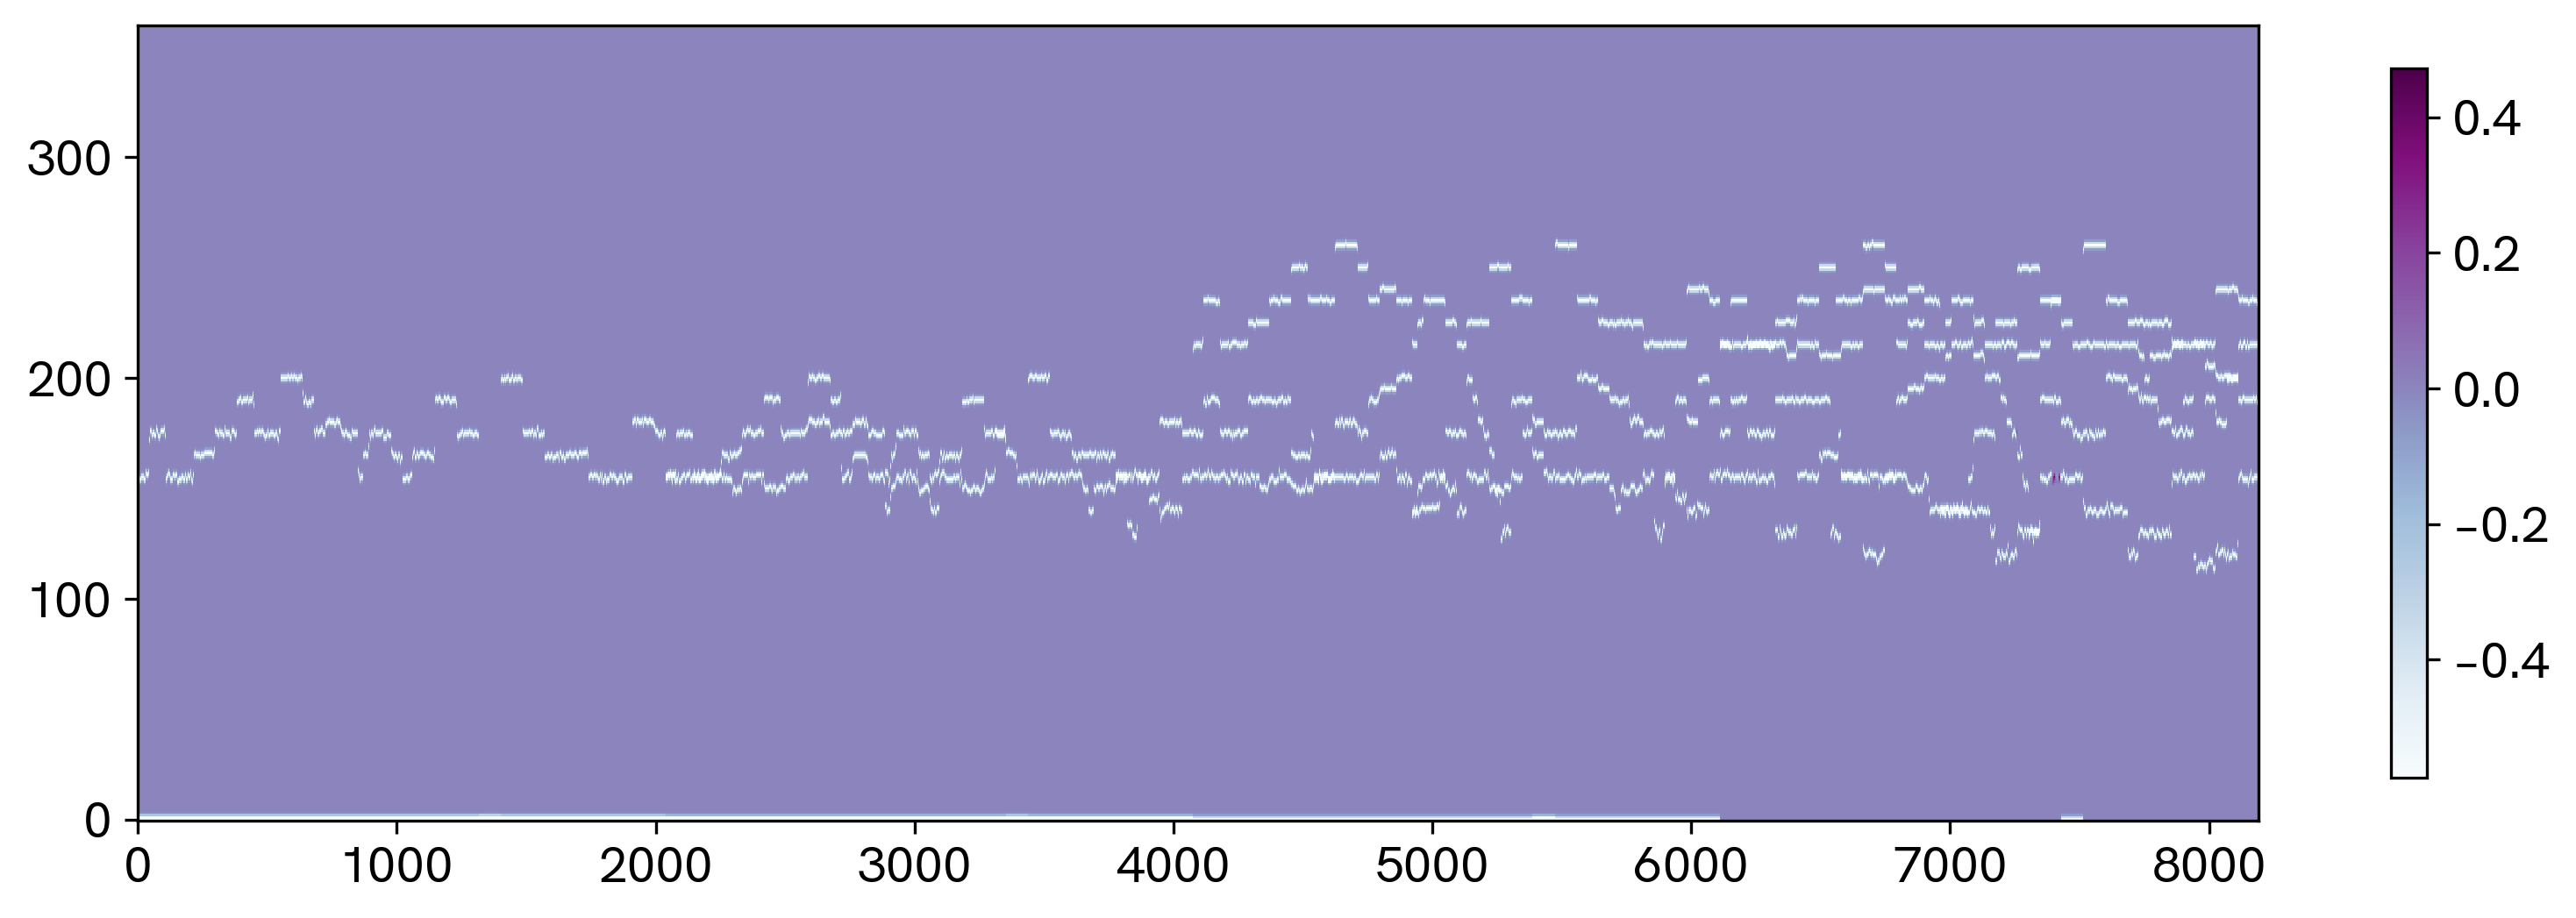

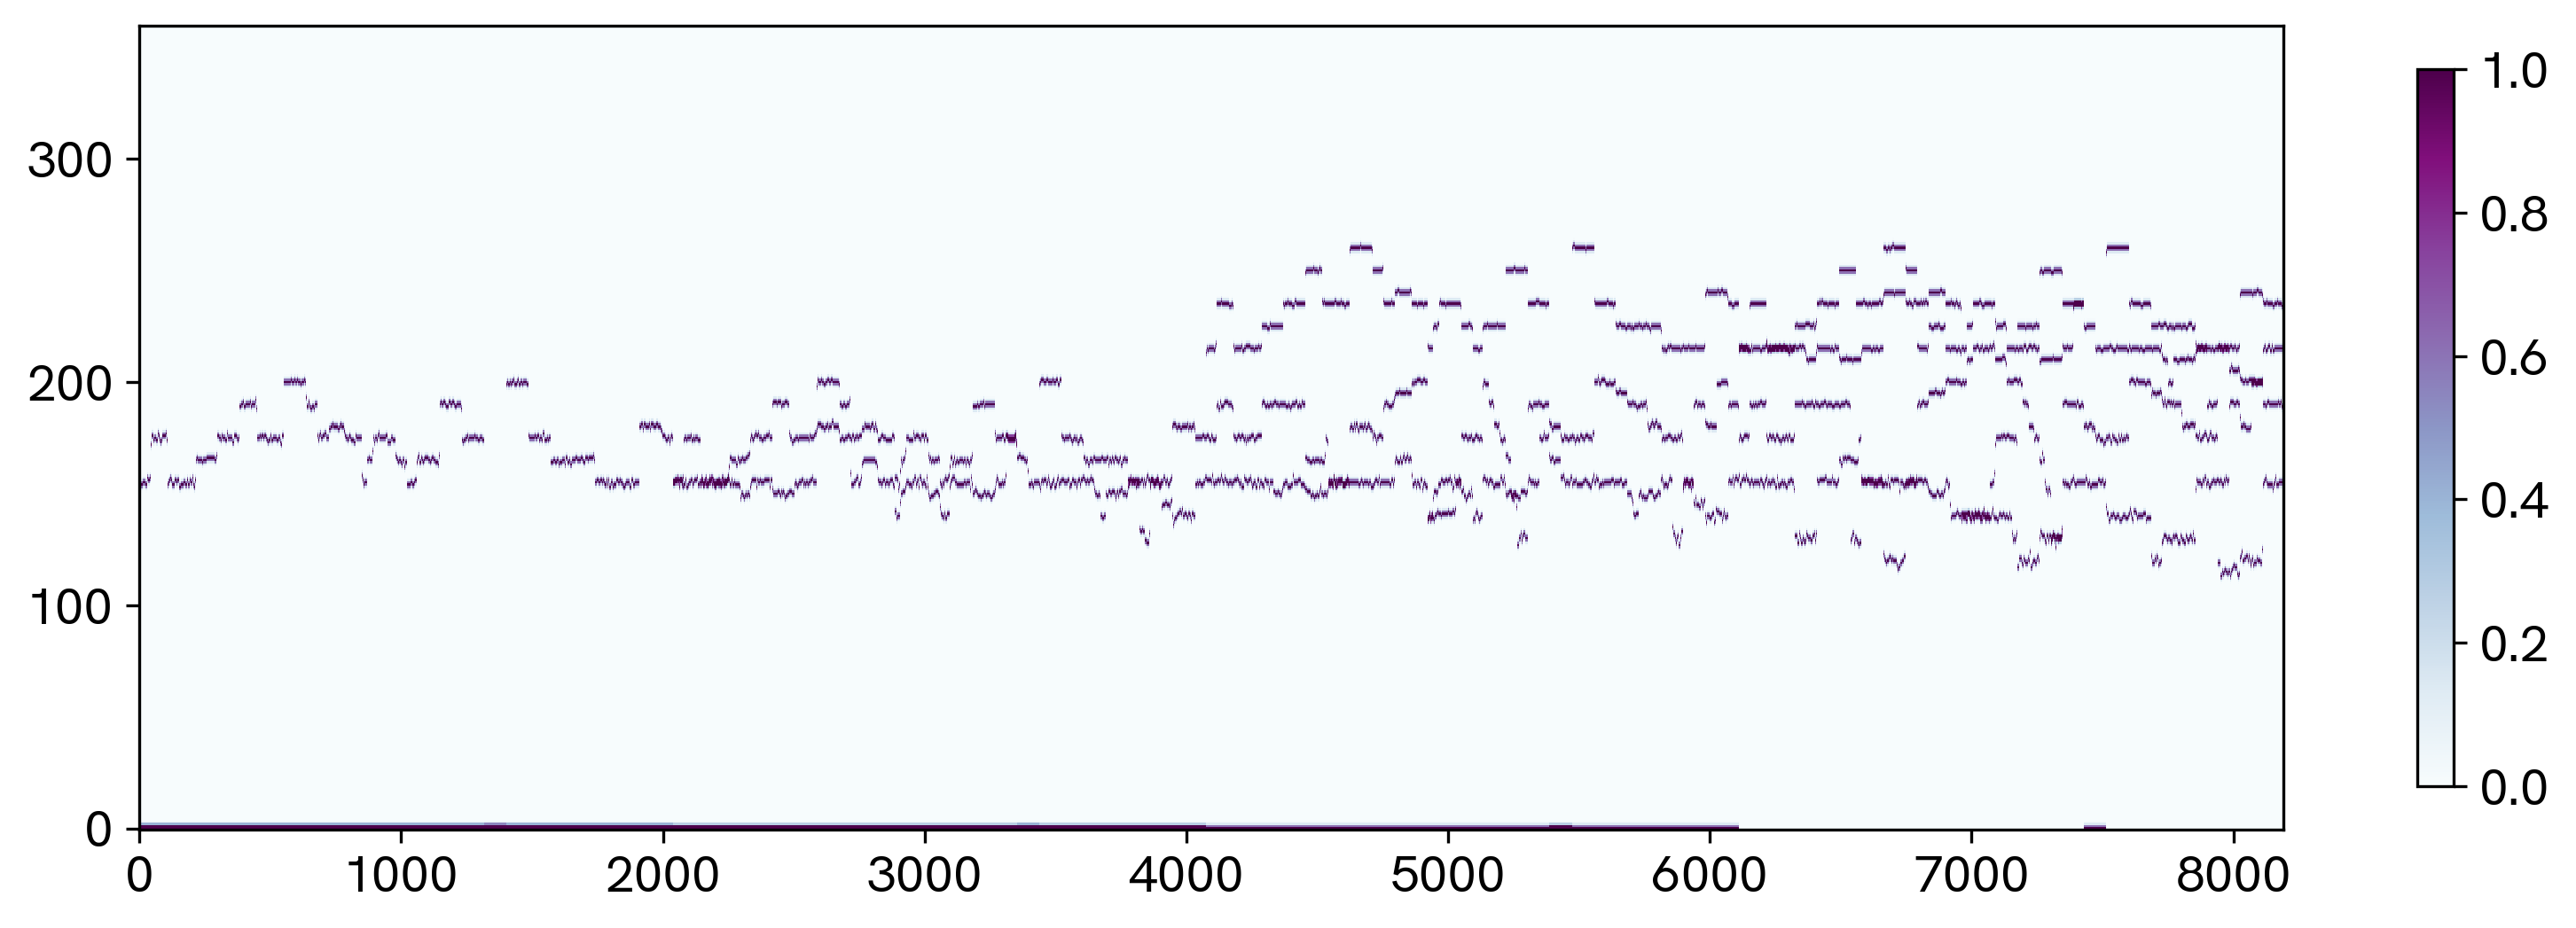

In [13]:
idx = 11
sscs.plot(upscale[:, :, idx], colorbar=True)
sscs.plot(mask[:, :, idx], colorbar=True)
sscs.plot(mix, colorbar=True)
#sscs.plot(s, colorbar=True)
#sscs.plot(a, colorbar=True)
#sscs.plot(t, colorbar=True)
#sscs.plot(b, colorbar=True)

## 6 - Playground

1/1 [==============================] - 1s 591ms/step
F-Scores:
Soprano: 0.9782714343750025
Alto: 0.9626464343750025
Tenor: 0.9541015125000026
Bass: 0.9694823718750025



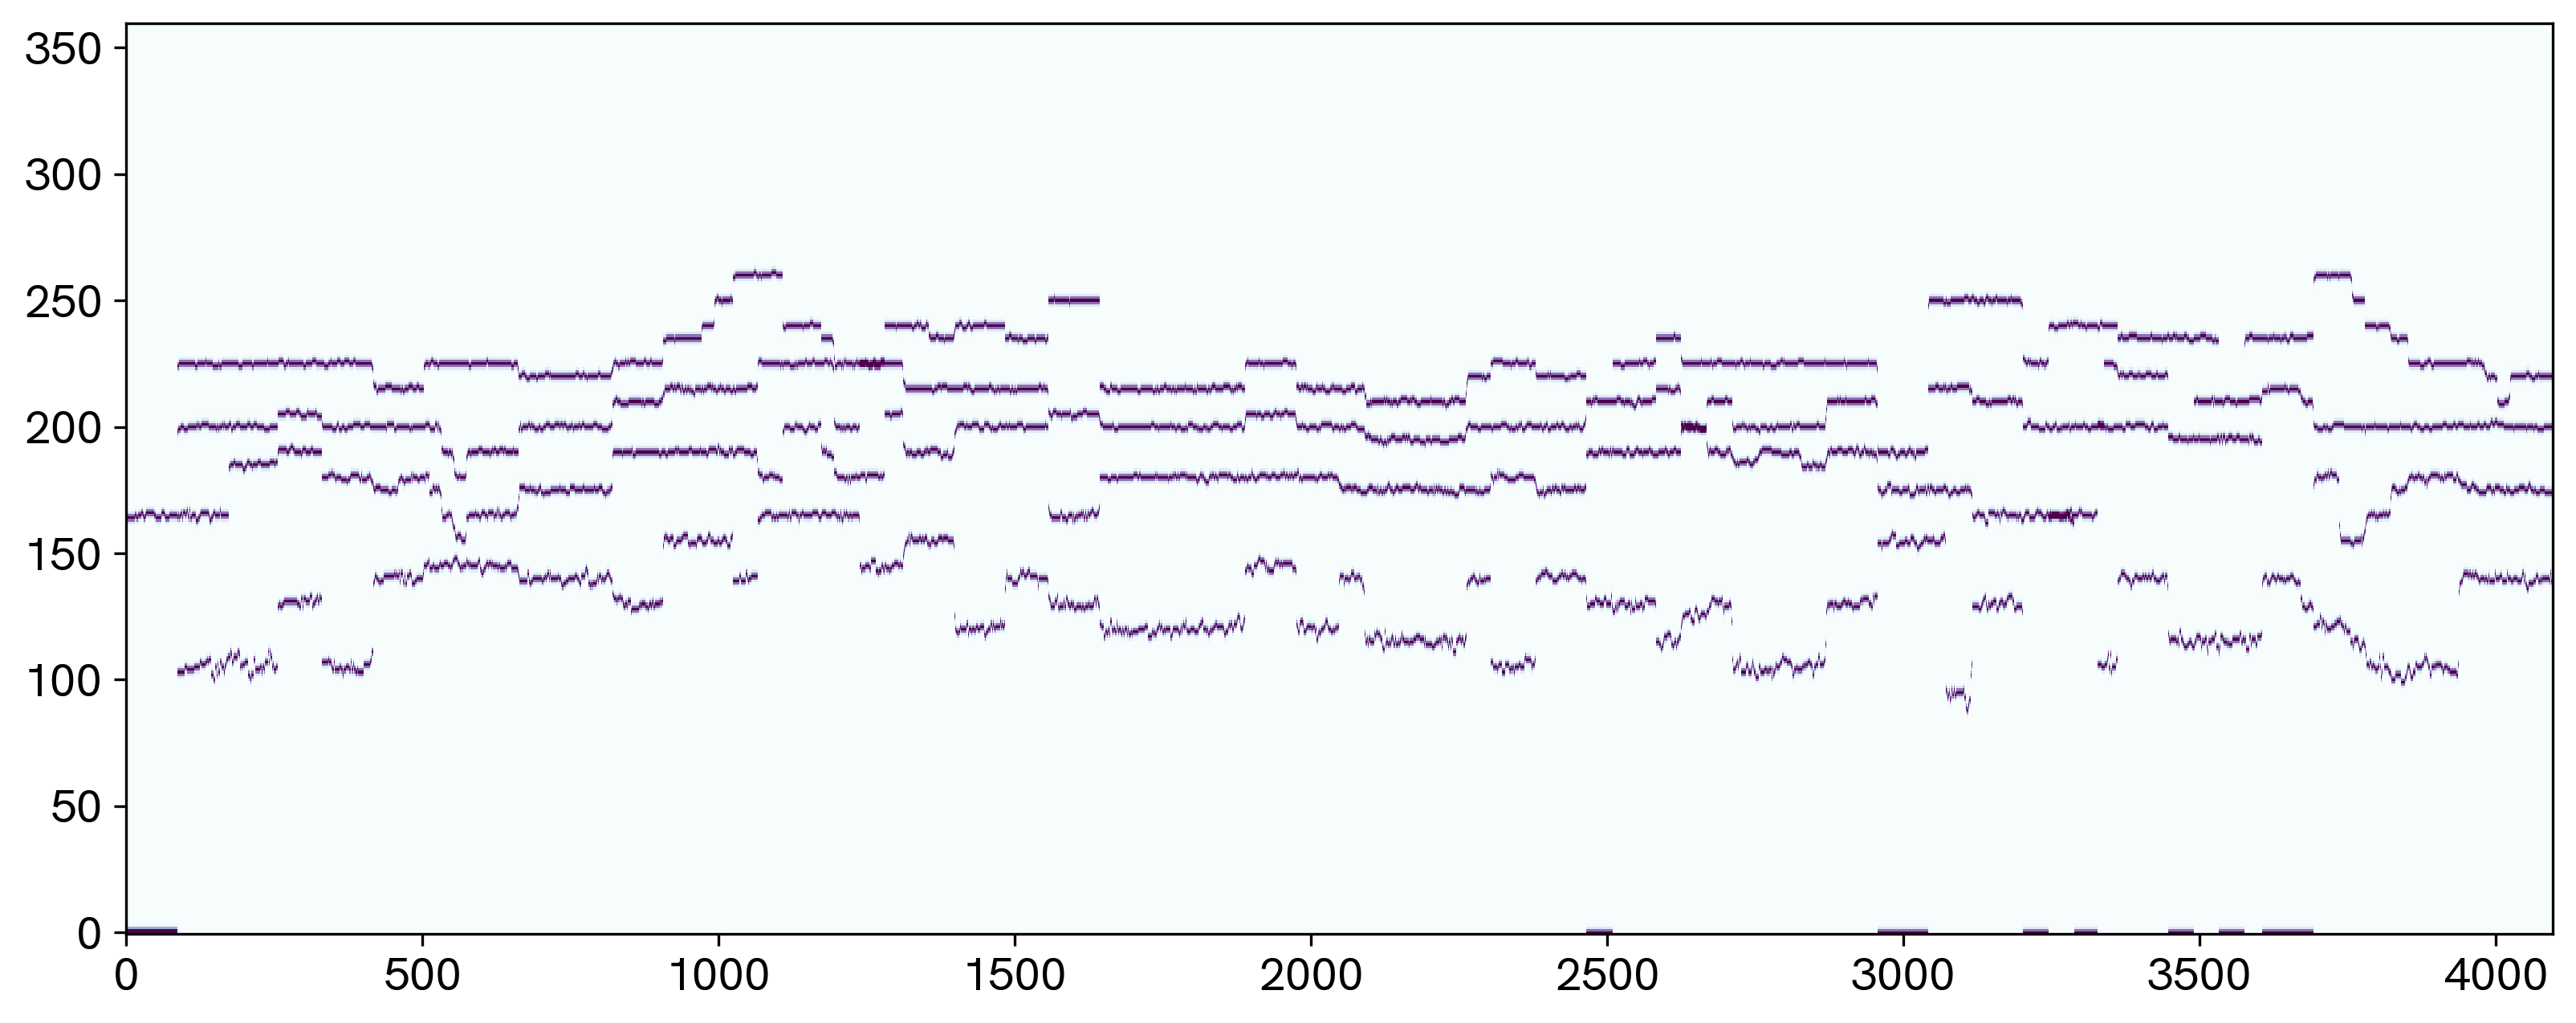

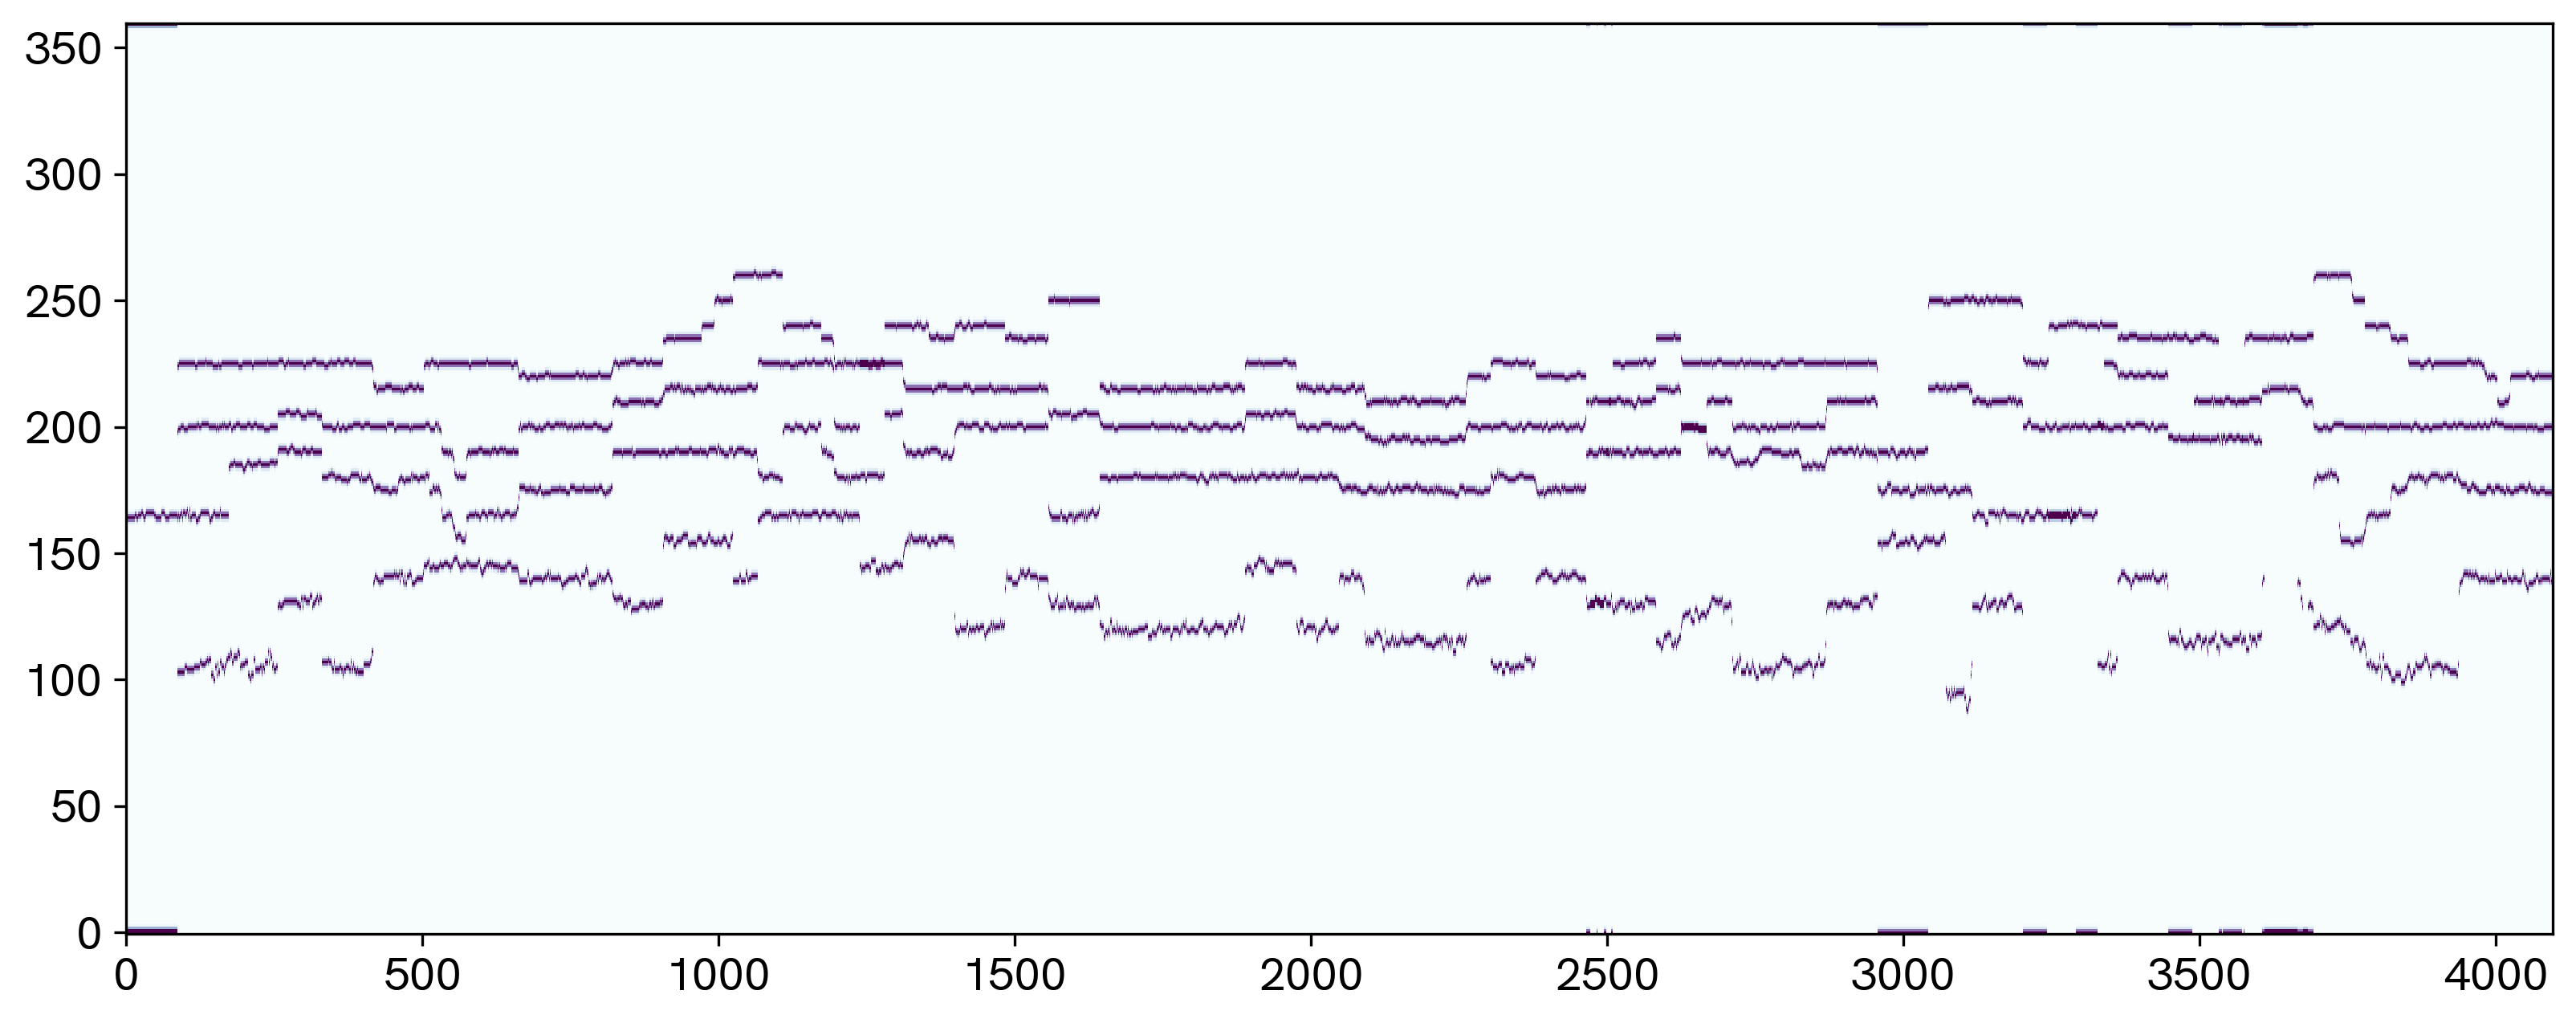

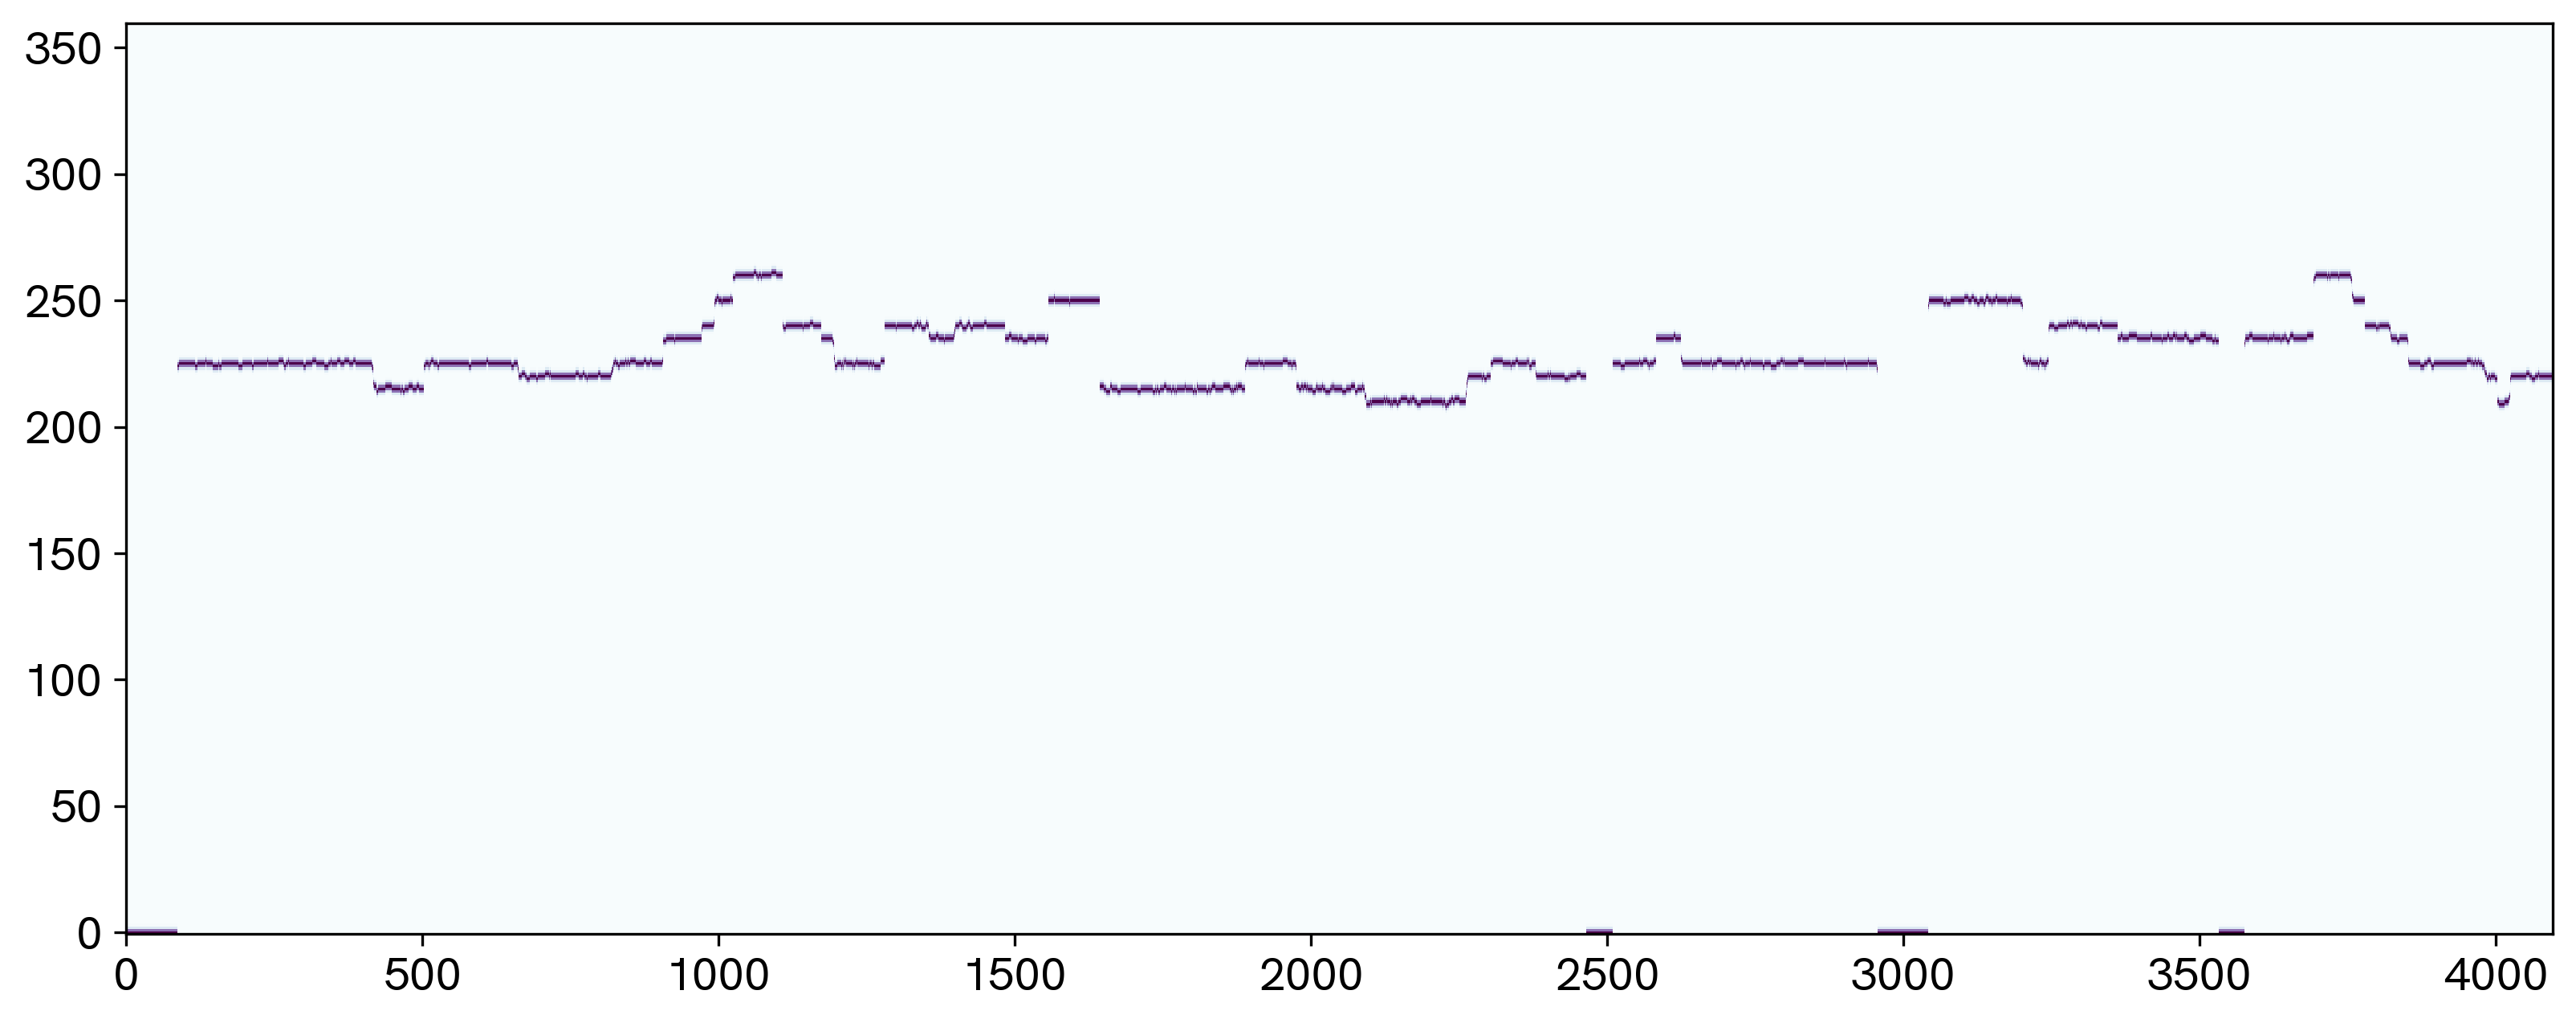

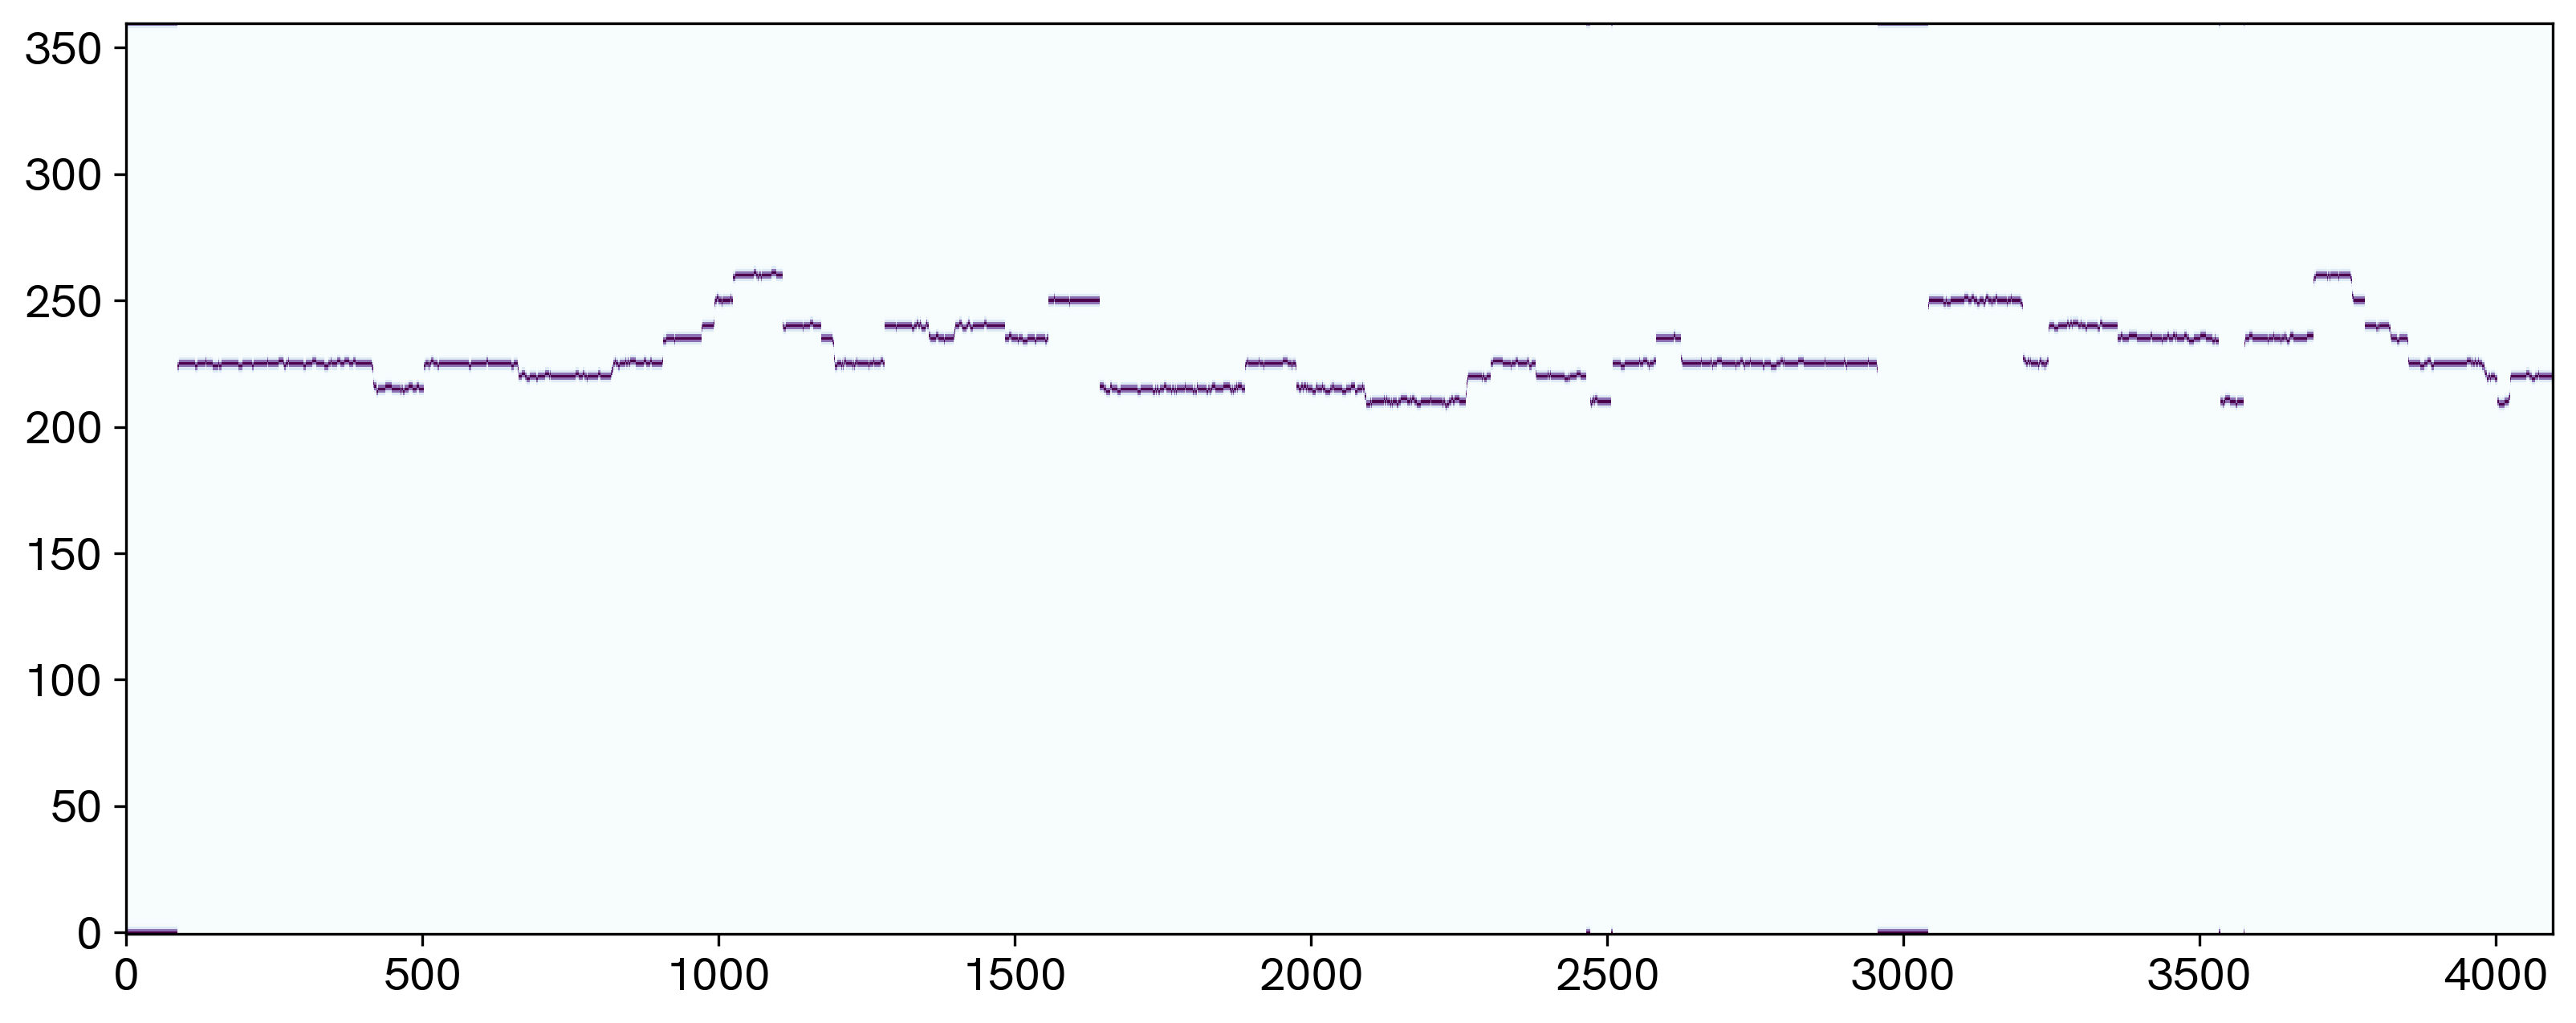

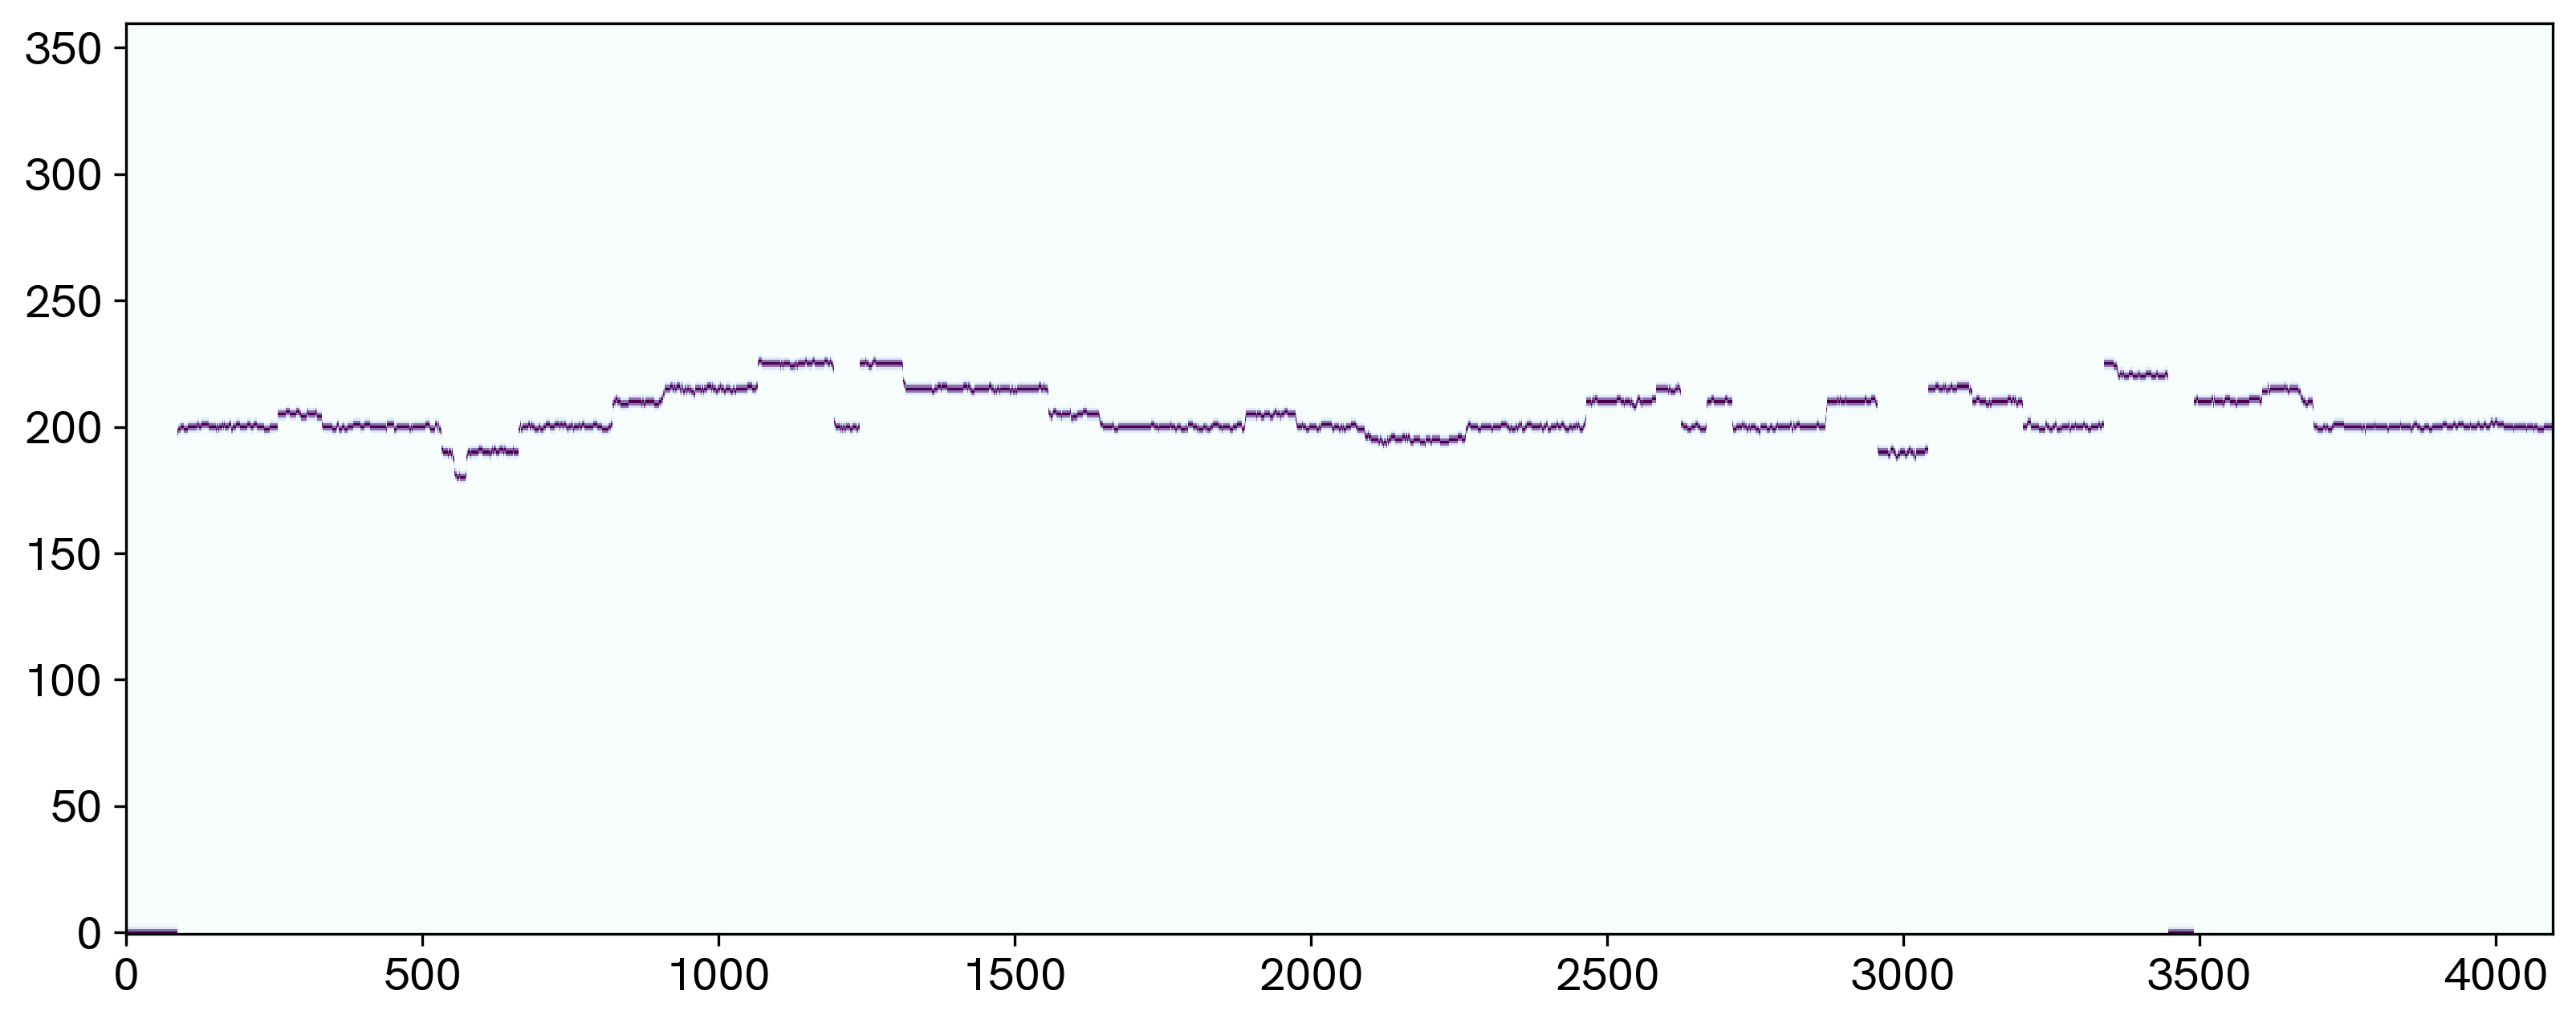

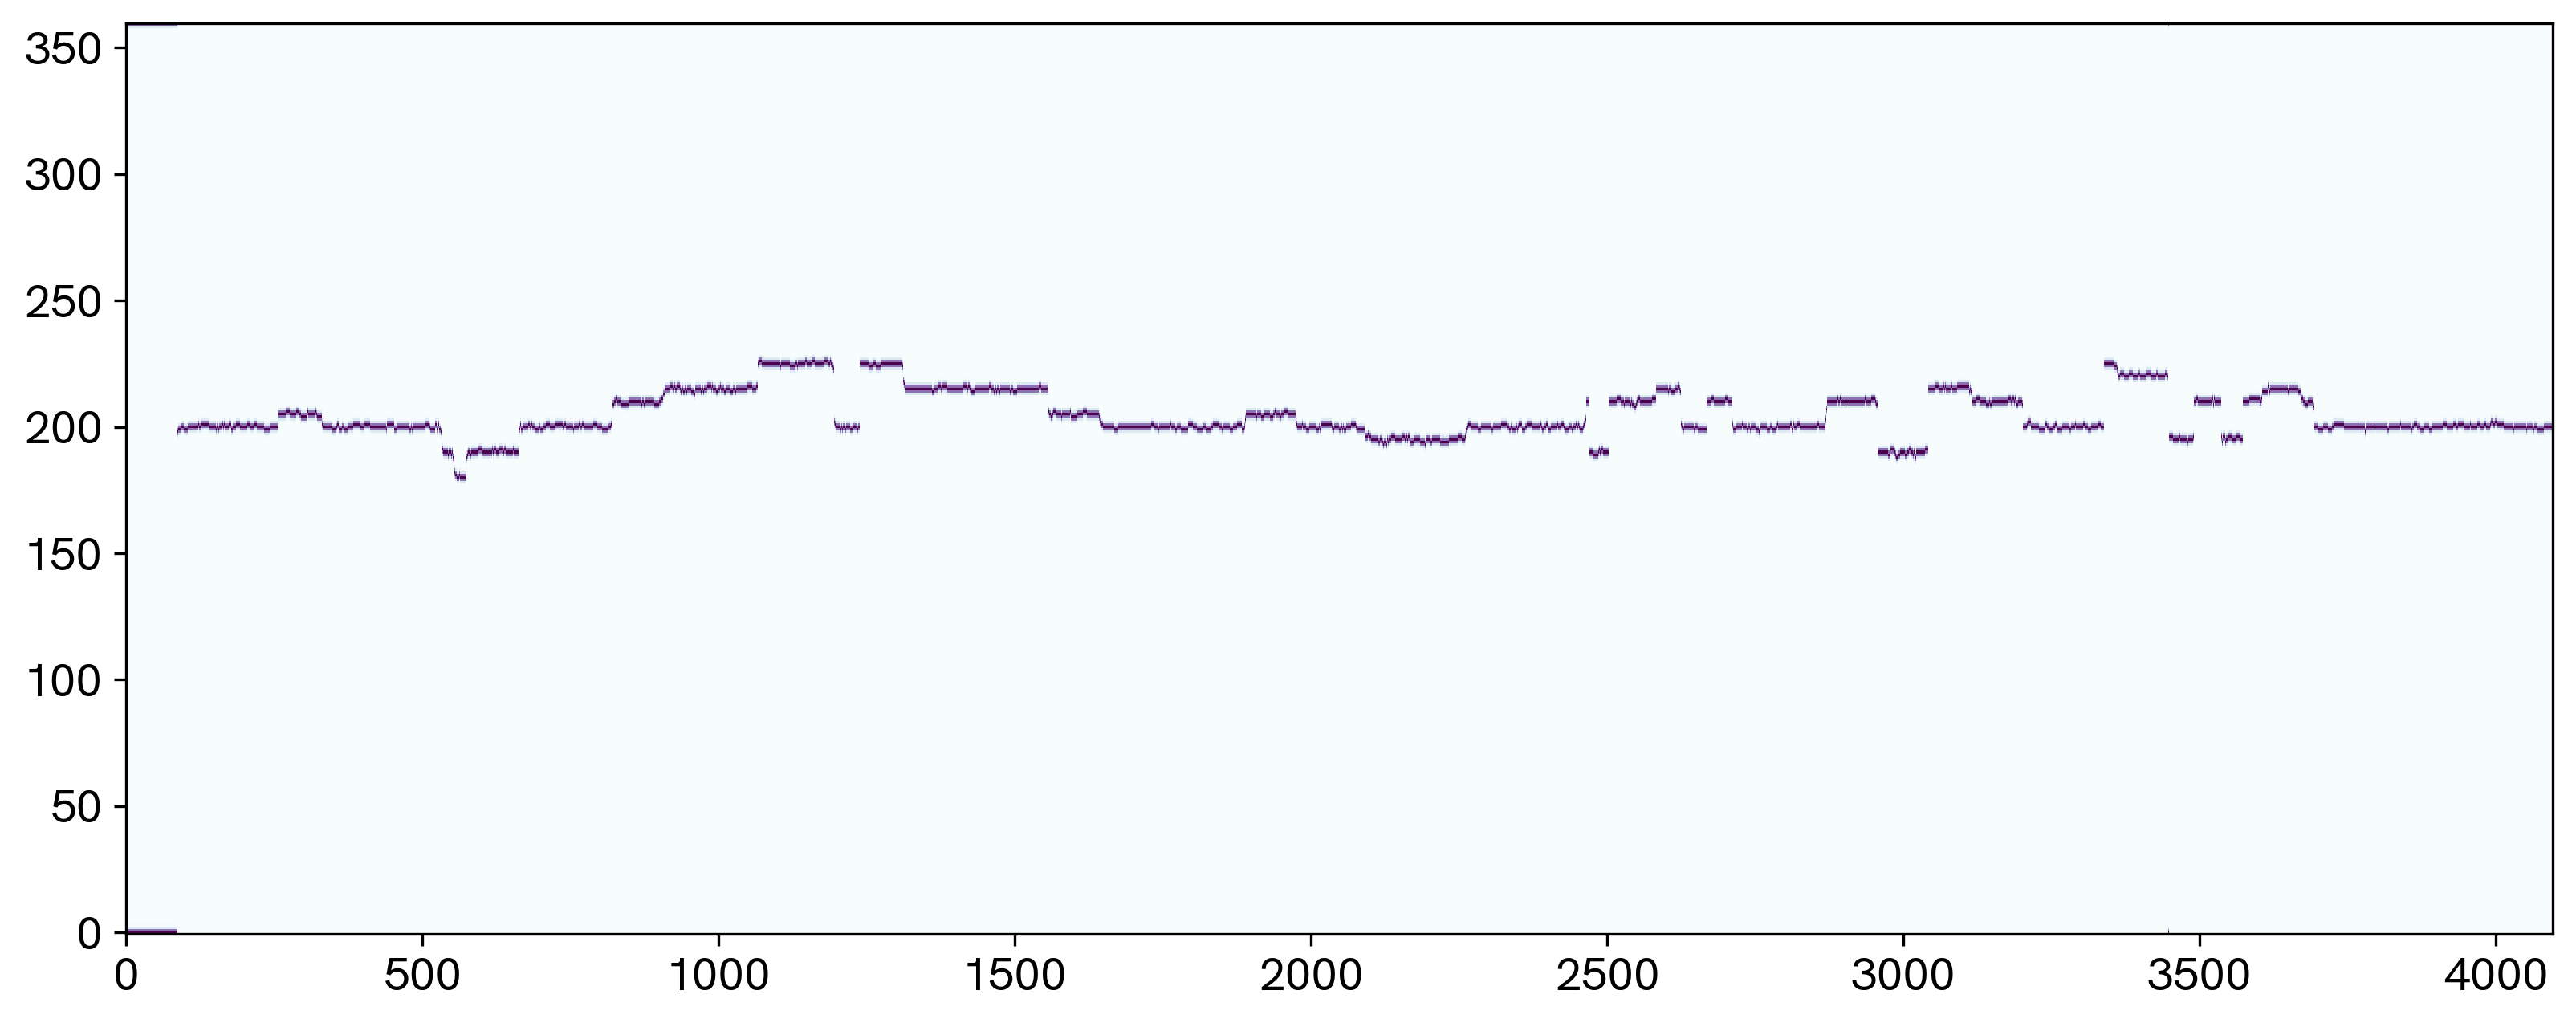

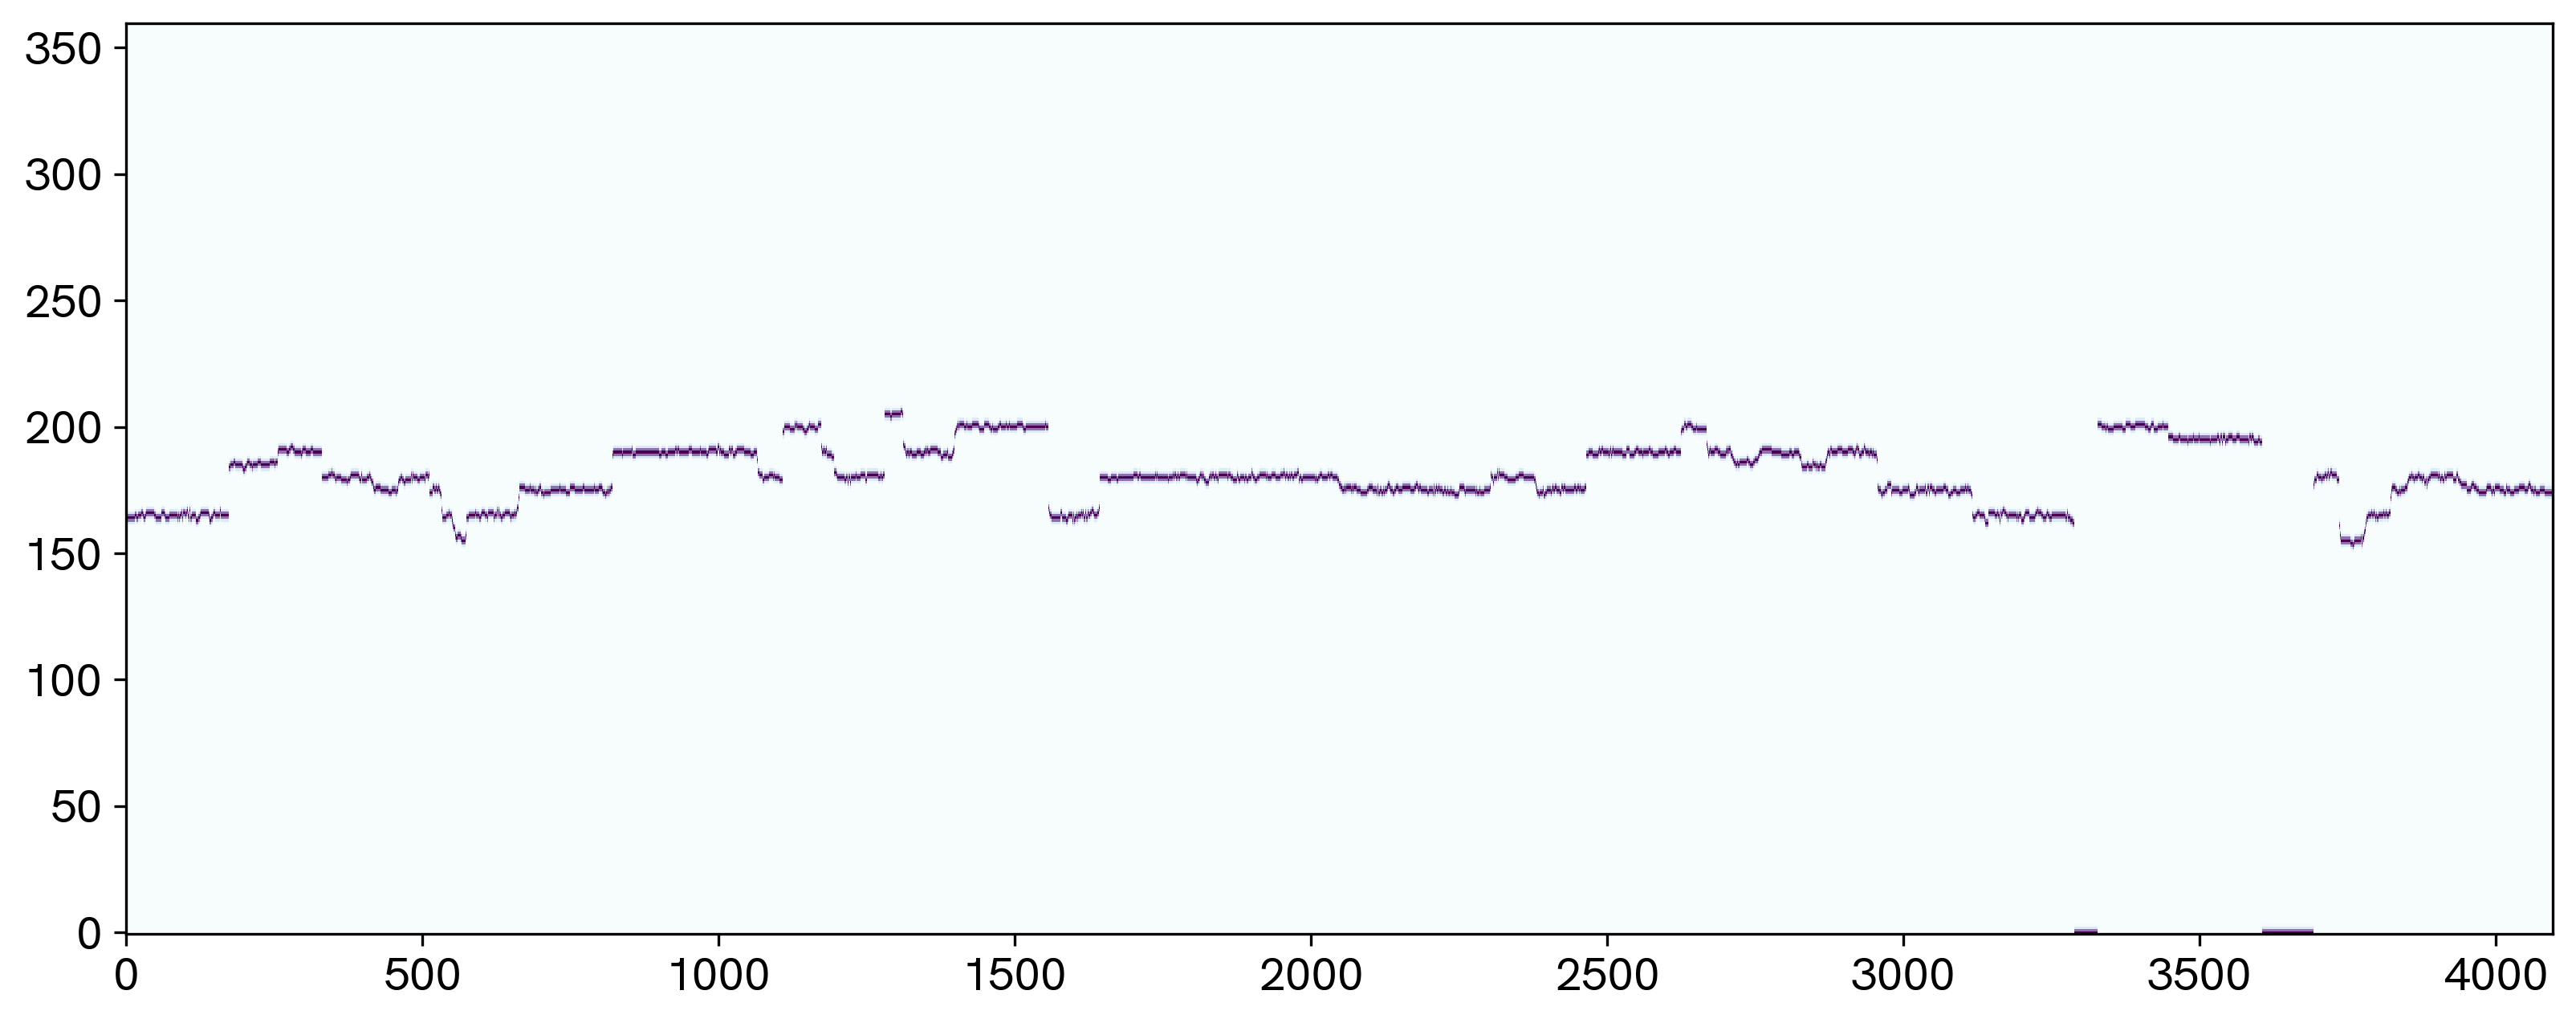

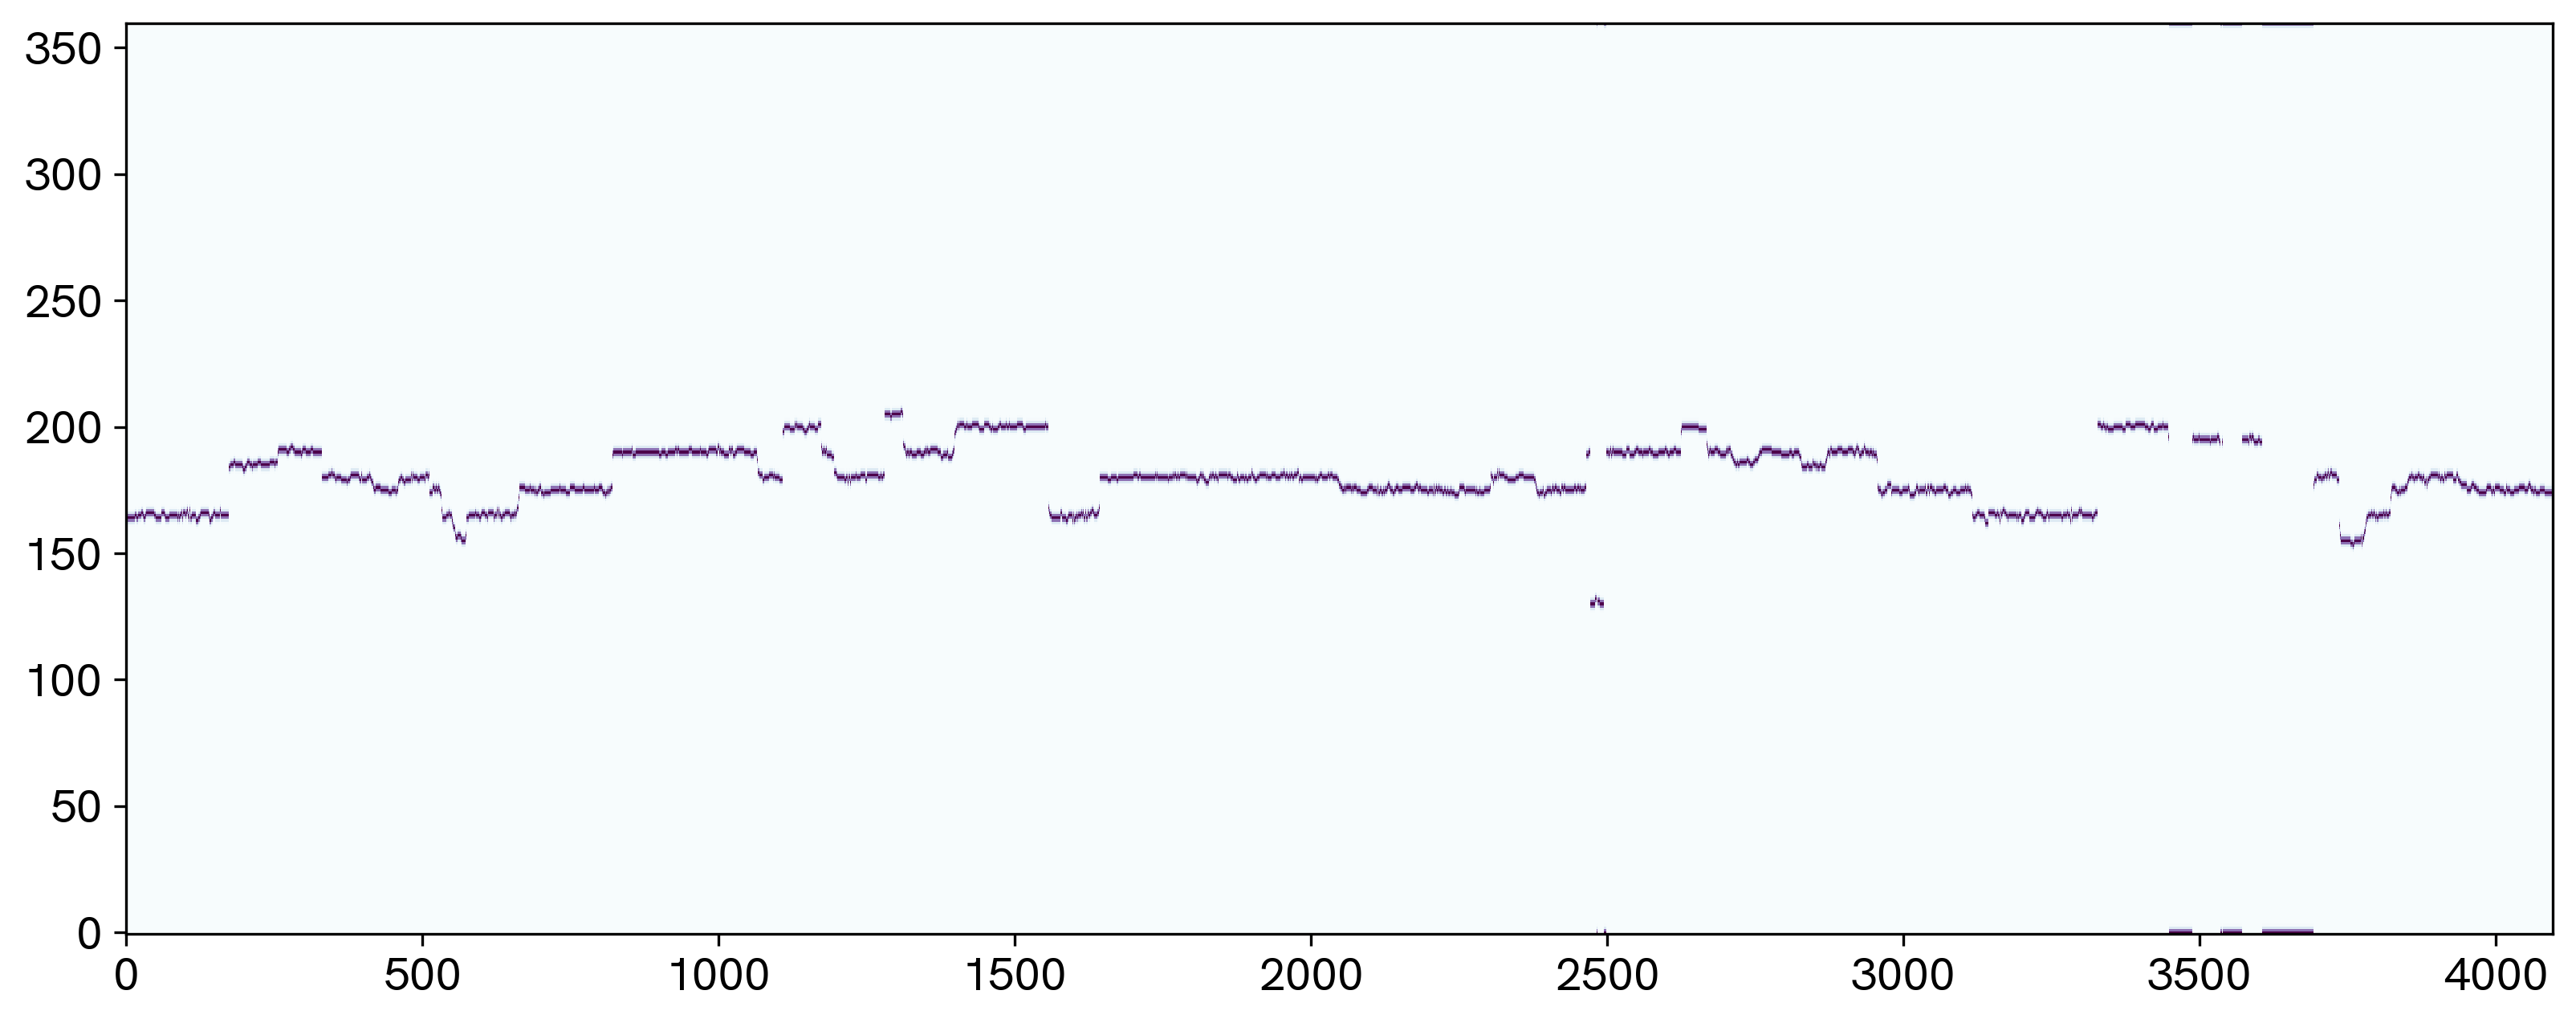

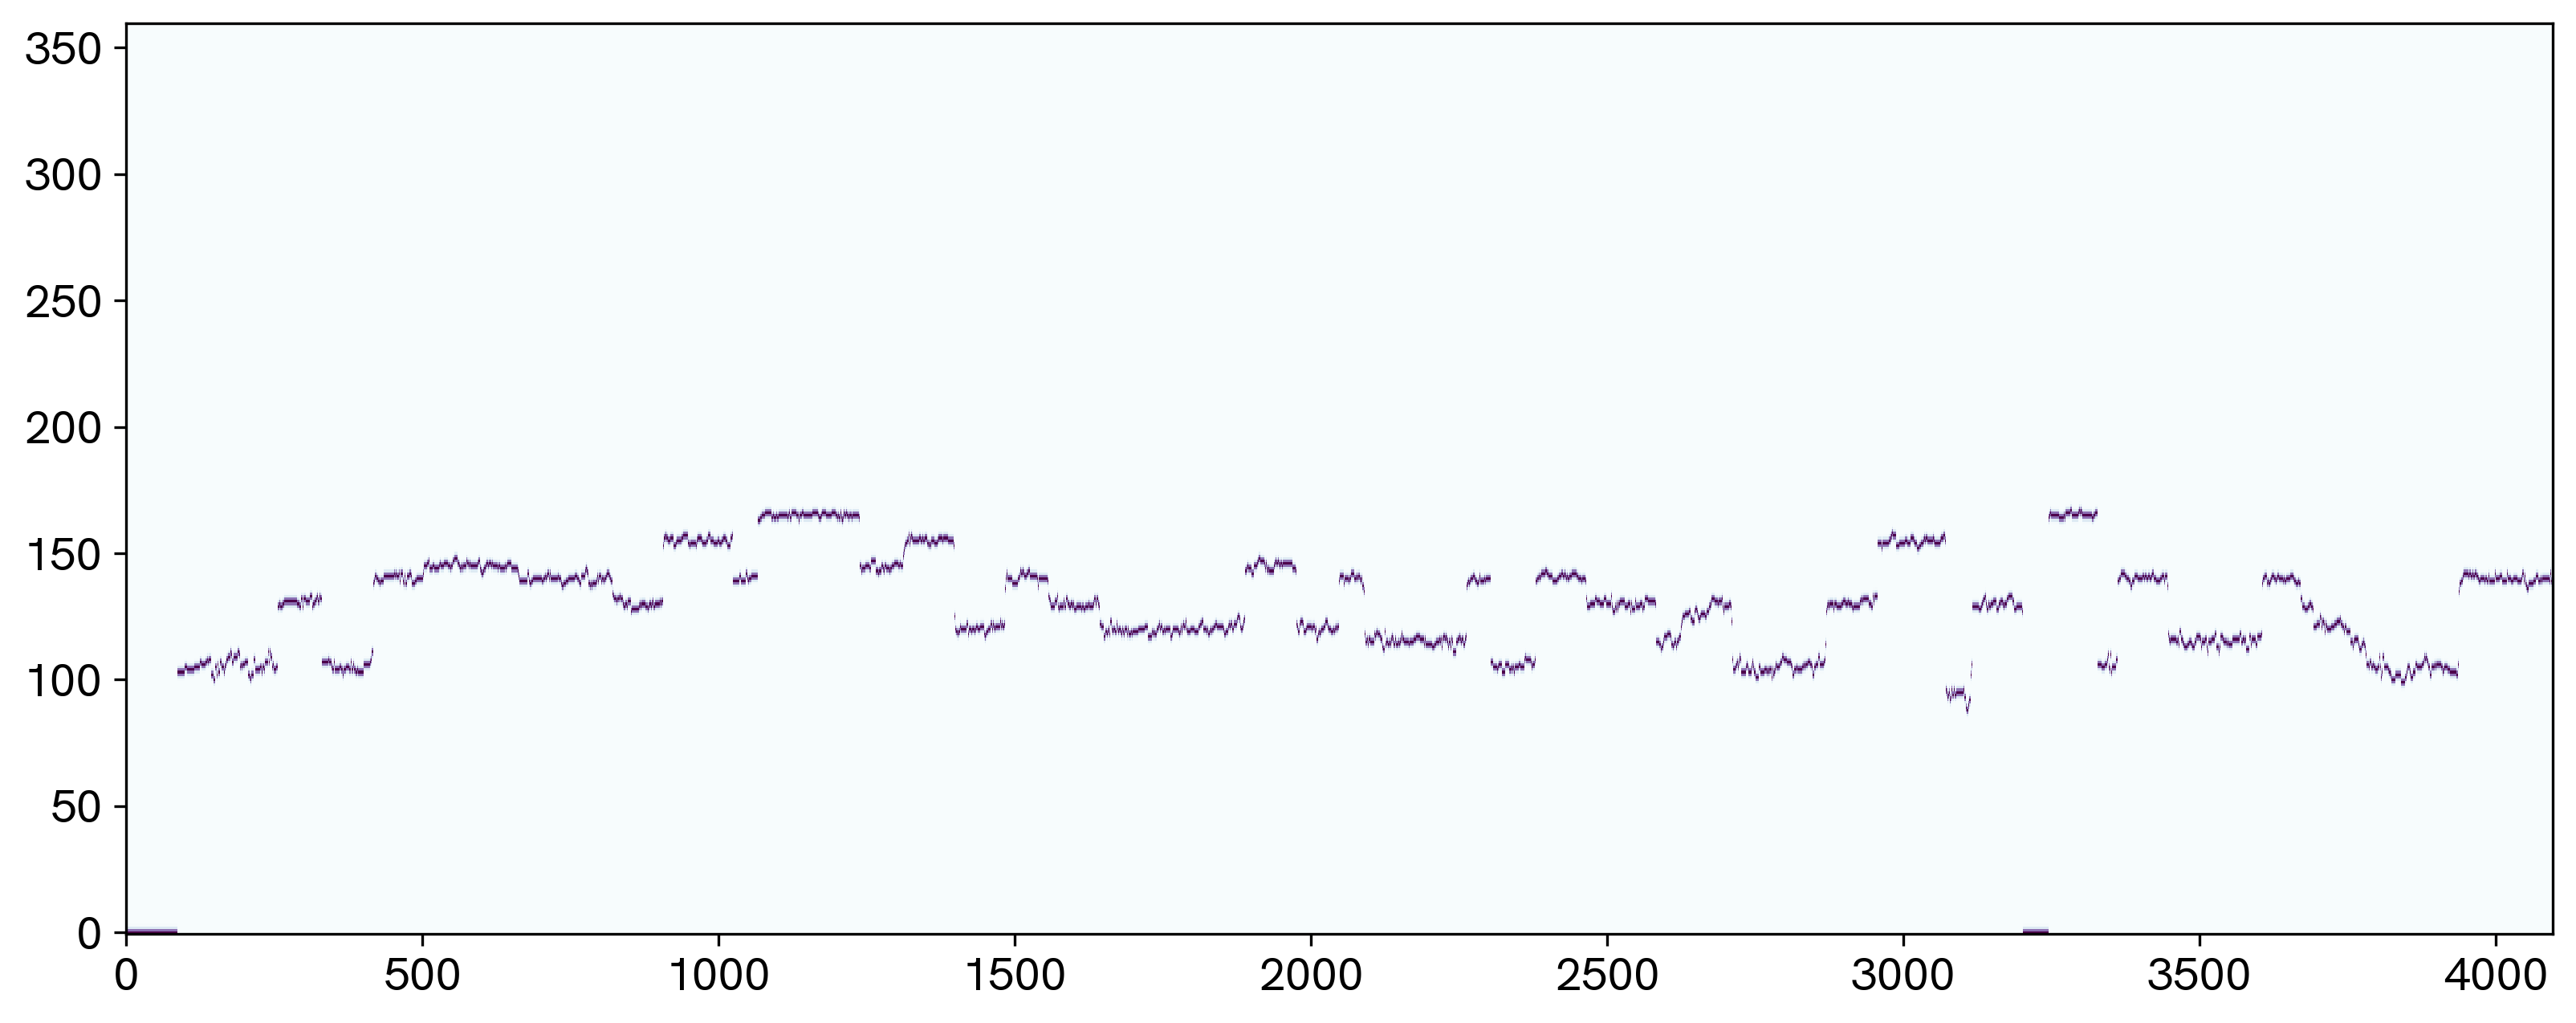

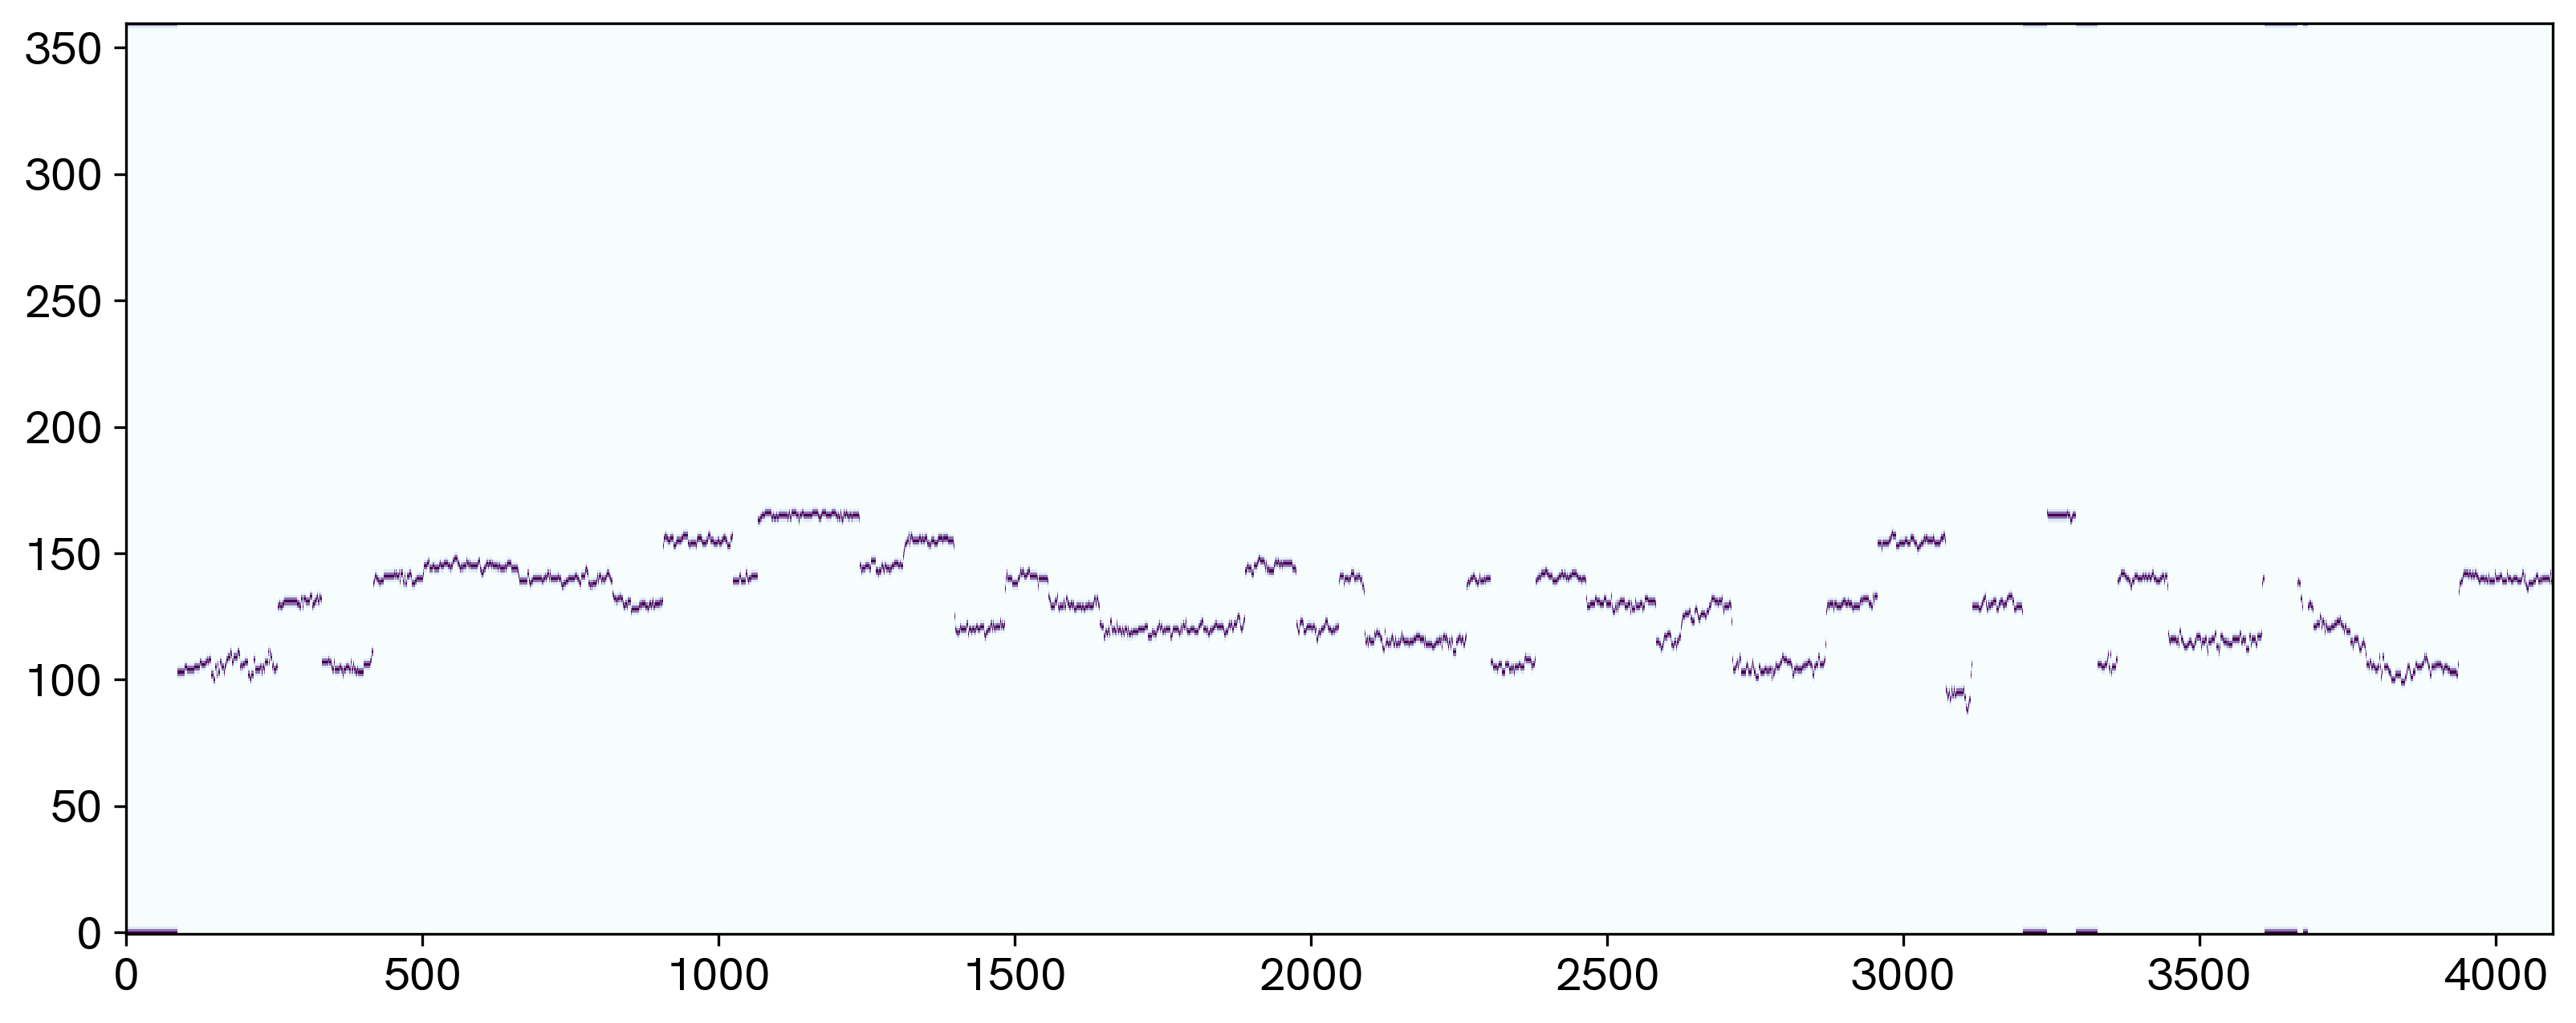

In [18]:
rand_song = sscs.pick_random_song(split='test')
mix, s, a, t, b = sscs.read_all_voice_splits(rand_song)

s_pred, a_pred, t_pred, b_pred = model.predict(mix)

mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
s = np.moveaxis(s, 0, 1).reshape(360, -1)
a = np.moveaxis(a, 0, 1).reshape(360, -1)
t = np.moveaxis(t, 0, 1).reshape(360, -1)
b = np.moveaxis(b, 0, 1).reshape(360, -1)

s_pred_postproc = sscs.prediction_postproc(s_pred).astype(np.float32)
a_pred_postproc = sscs.prediction_postproc(a_pred).astype(np.float32)
t_pred_postproc = sscs.prediction_postproc(t_pred).astype(np.float32)
b_pred_postproc = sscs.prediction_postproc(b_pred).astype(np.float32)
mix_pred_postproc = s_pred_postproc + a_pred_postproc + t_pred_postproc + b_pred_postproc
mix_pred_postproc = sscs.vectorized_downsample_limit(mix_pred_postproc)

s_fscore = sscs.f_score(s, s_pred_postproc)
a_fscore = sscs.f_score(a, a_pred_postproc)
t_fscore = sscs.f_score(t, t_pred_postproc)
b_fscore = sscs.f_score(b, b_pred_postproc)

print("F-Scores:")
print(f"Soprano: {s_fscore}")
print(f"Alto: {a_fscore}")
print(f"Tenor: {t_fscore}")
print(f"Bass: {b_fscore}")
print()

sscs.plot(mix)
sscs.plot(mix_pred_postproc)

sscs.plot(s)
sscs.plot(s_pred_postproc)

sscs.plot(a)
sscs.plot(a_pred_postproc)

sscs.plot(t)
sscs.plot(t_pred_postproc)

sscs.plot(b)
sscs.plot(b_pred_postproc)

sscs.song_to_midi(s, a, t, b, './MIDI/original.mid')
sscs.song_to_midi(s_pred_postproc, a_pred_postproc, t_pred_postproc, b_pred_postproc,
                  './MIDI/predicted.mid')